In [1]:
import gc
import sys
from statistics import mean
import time
import torch
from tqdm import tqdm
from torchinfo import summary
import numpy as np
import itertools
from pathlib import Path
from scipy import special
import matplotlib.pyplot as plt
import datetime
import torch.linalg as LA
from torch.distributions.laplace import Laplace

import utils
import models
import learning_utils
from configurations import args_parser, arguments



In [2]:
start_time = time.time()
args = arguments()
#boardio is for the the tensorboardx prensation and textio is for written documentation
boardio, textio, best_val_acc, path_best_model, last_model_path = utils.initializations(args)
textio.cprint(str(args) if args.__class__.__name__ == 'Namespace' else str(vars(args)))

#mnist_train_data, mnist_test_loader  = utils.data(args)





{'exp_name': None, 'eval': False, 'data': 'mnist', 'norm_std': 0.5, 'norm_mean': 0.5, 'train_batch_size': 20, 'test_batch_size': 1000, 'model': 'cnn2', 'num_users': 30, 'num_users_per_round': 5, 'local_epochs': 1, 'local_iterations': 100, 'global_epochs': 200, 'tau_min': 0.05, 'privacy_noise': 'laplace', 'epsilon_bar': 400, 'optimizer': 'sgd', 'lr': 0.01, 'momentum': 0.5, 'lr_scheduler': False, 'device': device(type='cuda'), 'seed': 0, 'zeta_coeff': 1.05, 'alpha': 5, 'beta': 2, 'gamma': 0.1, 'max_seconds': 300, 'method_choosing_users': 'fastest ones', 'data_truncation': 1750, 'choosing_users_verbose': False, 'save_best_model': False, 'privacy': True, 'privacy_choosing_users': True, 'epsilon_sum_deascent_coeff': 0.02, 'delta_f': 0.0008, 'snr_verbose': True}


In [3]:
# data
train_data, test_loader = utils.data(args)
#input in the CNNs is the number of channels and in linear models is the size of the flatten pictures
input, output, train_data, val_loader = utils.data_split(train_data, len(test_loader.dataset), args)

# model
if args.model == 'mlp':
    global_model = models.FC2Layer(input, output)
elif args.model == 'cnn2':
    global_model = models.CNN2Layer(input, output, args.data)
elif args.model == 'cnn3':
    if args.data == 'cifar10':
        global_model = models.CNN3LayerCifar()
    else:
        global_model = models.CNN3LayerMnist()
elif args.model == 'cnn5':
    if args.data == 'mnist' or args.data == 'fashion mnist':
        raise ValueError('CNN5 is not supported for MNIST type datasets')
    global_model = models.CNN5Layer(input, output)
elif args.model == 'linear':
    global_model = models.Linear(input, output)



textio.cprint(str(summary(global_model)).encode('utf-8', errors='ignore').decode('utf-8', errors='ignore'))
global_model = global_model.to(args.device)
print(f"global model's device: {next(global_model.parameters()).device}")

train_criterion = torch.nn.CrossEntropyLoss(reduction='mean')
test_criterion = torch.nn.CrossEntropyLoss(reduction='sum')

local_models = utils.federated_setup(global_model, train_data, args, i_i_d=True)
utils.update_data_equility_partititon(local_models, args)





Layer (type:depth-idx)                   Param #
CNN2Layer                                --
├─Conv2d: 1-1                            156
├─Conv2d: 1-2                            906
├─Linear: 1-3                            4,850
├─Linear: 1-4                            510
├─Dropout: 1-5                           --
├─Dropout: 1-6                           --
├─BatchNorm2d: 1-7                       12
├─BatchNorm1d: 1-8                       100
Total params: 6,534
Trainable params: 6,534
Non-trainable params: 0
global model's device: cuda:0


In [4]:
# for i in range(100):
#     local_models[0].update_privacy_violation_and_reward()
#     print(f"iteration {i}, next_privacy_term is {local_models[0].next_privacy_term}")

  0%|          | 0/200 [00:00<?, ?it/s]

user No.0 has been picked 1 and his deltas theta's mean is 7.356404967140406e-05, the added laplace noise var is 0.00010100333331111106
user No.1 has been picked 1 and his deltas theta's mean is 9.668608254287392e-05, the added laplace noise var is 0.00010100333331111106
user No.2 has been picked 1 and his deltas theta's mean is 6.808918988099322e-05, the added laplace noise var is 0.00010100333331111106
user No.3 has been picked 1 and his deltas theta's mean is 7.273899245774373e-05, the added laplace noise var is 0.00010100333331111106
user No.4 has been picked 1 and his deltas theta's mean is 7.694550731685013e-05, the added laplace noise var is 0.00010100333331111106


  0%|          | 1/200 [00:04<14:38,  4.41s/it]

global epoch 1 has been done artifficialy in 0.09 secs, the total time by now is 0.09 
 with avg train loss 2.310, val loss 2.304, avg val acc 9.66%
user No.0 has been picked 2 and his deltas theta's mean is 0.00011208932846784592, the added laplace noise var is 0.00010304373599116456
user No.1 has been picked 2 and his deltas theta's mean is 0.00012470064393710345, the added laplace noise var is 0.00010304373599116456
user No.2 has been picked 2 and his deltas theta's mean is 9.02568717719987e-05, the added laplace noise var is 0.00010304373599116456
user No.3 has been picked 2 and his deltas theta's mean is 0.00010146331624127924, the added laplace noise var is 0.00010304373599116456
user No.4 has been picked 2 and his deltas theta's mean is 9.549267997499555e-05, the added laplace noise var is 0.00010304373599116456


  1%|          | 2/200 [00:06<09:40,  2.93s/it]

global epoch 2 has been done artifficialy in 0.10 secs, the total time by now is 0.18 
 with avg train loss 2.308, val loss 2.303, avg val acc 9.65%
user No.0 has been picked 3 and his deltas theta's mean is 0.00010468647087691352, the added laplace noise var is 0.00010512535753954933
user No.1 has been picked 3 and his deltas theta's mean is 0.00013530996511690319, the added laplace noise var is 0.00010512535753954933
user No.2 has been picked 3 and his deltas theta's mean is 9.395820961799473e-05, the added laplace noise var is 0.00010512535753954933
user No.3 has been picked 3 and his deltas theta's mean is 9.700824011815712e-05, the added laplace noise var is 0.00010512535753954933
user No.4 has been picked 3 and his deltas theta's mean is 0.00011053986236220226, the added laplace noise var is 0.00010512535753954933


  2%|▏         | 3/200 [00:08<08:09,  2.48s/it]

global epoch 3 has been done artifficialy in 0.11 secs, the total time by now is 0.29 
 with avg train loss 2.307, val loss 2.301, avg val acc 9.64%
user No.0 has been picked 4 and his deltas theta's mean is 0.00011506370356073603, the added laplace noise var is 0.00010724903063264004
user No.1 has been picked 4 and his deltas theta's mean is 0.00013025641965214163, the added laplace noise var is 0.00010724903063264004
user No.2 has been picked 4 and his deltas theta's mean is 9.402751311426982e-05, the added laplace noise var is 0.00010724903063264004
user No.3 has been picked 4 and his deltas theta's mean is 0.00010352922981837764, the added laplace noise var is 0.00010724903063264004
user No.4 has been picked 4 and his deltas theta's mean is 0.00010911862773355097, the added laplace noise var is 0.00010724903063264004


  2%|▏         | 4/200 [00:10<07:23,  2.26s/it]

global epoch 4 has been done artifficialy in 0.12 secs, the total time by now is 0.41 
 with avg train loss 2.305, val loss 2.300, avg val acc 9.63%
user No.0 has been picked 5 and his deltas theta's mean is 0.00011349734268151224, the added laplace noise var is 0.00010941560476798997
user No.1 has been picked 5 and his deltas theta's mean is 0.00013464814401231706, the added laplace noise var is 0.00010941560476798997
user No.2 has been picked 5 and his deltas theta's mean is 9.197017789119855e-05, the added laplace noise var is 0.00010941560476798997
user No.3 has been picked 5 and his deltas theta's mean is 0.00010723851301008835, the added laplace noise var is 0.00010941560476798997
user No.4 has been picked 5 and his deltas theta's mean is 0.00010584900883259252, the added laplace noise var is 0.00010941560476798997


  2%|▎         | 5/200 [00:12<07:02,  2.17s/it]

global epoch 5 has been done artifficialy in 0.12 secs, the total time by now is 0.53 
 with avg train loss 2.303, val loss 2.298, avg val acc 9.65%
user No.0 has been picked 6 and his deltas theta's mean is 0.00011122728756163269, the added laplace noise var is 0.00011162594660414125
user No.1 has been picked 6 and his deltas theta's mean is 0.00013049176777713, the added laplace noise var is 0.00011162594660414125
user No.2 has been picked 6 and his deltas theta's mean is 0.00010296217806171626, the added laplace noise var is 0.00011162594660414125
user No.3 has been picked 6 and his deltas theta's mean is 0.0001025764795485884, the added laplace noise var is 0.00011162594660414125
user No.4 has been picked 6 and his deltas theta's mean is 0.00011327241372782737, the added laplace noise var is 0.00011162594660414125


  3%|▎         | 6/200 [00:14<06:50,  2.12s/it]

global epoch 6 has been done artifficialy in 0.09 secs, the total time by now is 0.62 
 with avg train loss 2.301, val loss 2.297, avg val acc 9.67%
user No.0 has been picked 7 and his deltas theta's mean is 0.00011001017992384732, the added laplace noise var is 0.00011388094030729999
user No.1 has been picked 7 and his deltas theta's mean is 0.00013748831406701356, the added laplace noise var is 0.00011388094030729999
user No.2 has been picked 7 and his deltas theta's mean is 9.631286229705438e-05, the added laplace noise var is 0.00011388094030729999
user No.3 has been picked 7 and his deltas theta's mean is 0.00010261945863021538, the added laplace noise var is 0.00011388094030729999
user No.4 has been picked 7 and his deltas theta's mean is 0.00010544185352046043, the added laplace noise var is 0.00011388094030729999


  4%|▎         | 7/200 [00:16<06:41,  2.08s/it]

global epoch 7 has been done artifficialy in 0.11 secs, the total time by now is 0.73 
 with avg train loss 2.299, val loss 2.295, avg val acc 9.76%
user No.0 has been picked 8 and his deltas theta's mean is 0.00011043166887247935, the added laplace noise var is 0.00011618148790501444
user No.1 has been picked 8 and his deltas theta's mean is 0.000132571323774755, the added laplace noise var is 0.00011618148790501444
user No.2 has been picked 8 and his deltas theta's mean is 9.648663399275392e-05, the added laplace noise var is 0.00011618148790501444
user No.3 has been picked 8 and his deltas theta's mean is 0.00010358828149037436, the added laplace noise var is 0.00011618148790501444
user No.4 has been picked 8 and his deltas theta's mean is 0.00011381359945517033, the added laplace noise var is 0.00011618148790501444


  4%|▍         | 8/200 [00:18<06:38,  2.07s/it]

global epoch 8 has been done artifficialy in 0.13 secs, the total time by now is 0.86 
 with avg train loss 2.297, val loss 2.293, avg val acc 9.81%
user No.0 has been picked 9 and his deltas theta's mean is 0.00011359225754858926, the added laplace noise var is 0.00011852850964699805
user No.1 has been picked 9 and his deltas theta's mean is 0.00014078959065955132, the added laplace noise var is 0.00011852850964699805
user No.2 has been picked 9 and his deltas theta's mean is 0.00010000442853197455, the added laplace noise var is 0.00011852850964699805
user No.3 has been picked 9 and his deltas theta's mean is 0.00010712340008467436, the added laplace noise var is 0.00011852850964699805
user No.4 has been picked 9 and his deltas theta's mean is 0.00011074091162299737, the added laplace noise var is 0.00011852850964699805


  4%|▍         | 9/200 [00:20<06:37,  2.08s/it]

global epoch 9 has been done artifficialy in 0.10 secs, the total time by now is 0.96 
 with avg train loss 2.295, val loss 2.292, avg val acc 9.95%
user No.0 has been picked 10 and his deltas theta's mean is 0.00011923279816983268, the added laplace noise var is 0.00012092294437324167
user No.1 has been picked 10 and his deltas theta's mean is 0.0001361399336019531, the added laplace noise var is 0.00012092294437324167
user No.2 has been picked 10 and his deltas theta's mean is 0.00010266950266668573, the added laplace noise var is 0.00012092294437324167
user No.3 has been picked 10 and his deltas theta's mean is 0.0001078262212104164, the added laplace noise var is 0.00012092294437324167
user No.4 has been picked 10 and his deltas theta's mean is 0.00011276388249825686, the added laplace noise var is 0.00012092294437324167


  5%|▌         | 10/200 [00:22<06:37,  2.09s/it]

global epoch 10 has been done artifficialy in 0.10 secs, the total time by now is 1.06 
 with avg train loss 2.293, val loss 2.290, avg val acc 10.21%
user No.0 has been picked 11 and his deltas theta's mean is 0.00011420606460887939, the added laplace noise var is 0.000123365749889562
user No.1 has been picked 11 and his deltas theta's mean is 0.0001374808489345014, the added laplace noise var is 0.000123365749889562
user No.2 has been picked 11 and his deltas theta's mean is 0.0001077575288945809, the added laplace noise var is 0.000123365749889562
user No.3 has been picked 11 and his deltas theta's mean is 0.00011123906006105244, the added laplace noise var is 0.000123365749889562
user No.4 has been picked 11 and his deltas theta's mean is 0.00011662593897199258, the added laplace noise var is 0.000123365749889562


  6%|▌         | 11/200 [00:24<06:36,  2.10s/it]

global epoch 11 has been done artifficialy in 0.10 secs, the total time by now is 1.17 
 with avg train loss 2.291, val loss 2.288, avg val acc 10.45%
user No.0 has been picked 12 and his deltas theta's mean is 0.00011625934712355956, the added laplace noise var is 0.00012585790335073674
user No.1 has been picked 12 and his deltas theta's mean is 0.0001411515404470265, the added laplace noise var is 0.00012585790335073674
user No.2 has been picked 12 and his deltas theta's mean is 9.801823034649715e-05, the added laplace noise var is 0.00012585790335073674
user No.3 has been picked 12 and his deltas theta's mean is 0.00010807933722389862, the added laplace noise var is 0.00012585790335073674
user No.4 has been picked 12 and his deltas theta's mean is 0.00011543743312358856, the added laplace noise var is 0.00012585790335073674


  6%|▌         | 12/200 [00:26<06:32,  2.09s/it]

global epoch 12 has been done artifficialy in 0.09 secs, the total time by now is 1.26 
 with avg train loss 2.288, val loss 2.286, avg val acc 10.75%
user No.0 has been picked 13 and his deltas theta's mean is 0.00011682861804729328, the added laplace noise var is 0.00012840040165137956
user No.1 has been picked 13 and his deltas theta's mean is 0.0001388152304571122, the added laplace noise var is 0.00012840040165137956
user No.2 has been picked 13 and his deltas theta's mean is 9.96250455500558e-05, the added laplace noise var is 0.00012840040165137956
user No.3 has been picked 13 and his deltas theta's mean is 0.00011417065252317116, the added laplace noise var is 0.00012840040165137956
user No.4 has been picked 13 and his deltas theta's mean is 0.00012082762259524316, the added laplace noise var is 0.00012840040165137956


  6%|▋         | 13/200 [00:28<06:29,  2.08s/it]

global epoch 13 has been done artifficialy in 0.12 secs, the total time by now is 1.38 
 with avg train loss 2.286, val loss 2.284, avg val acc 10.92%
user No.0 has been picked 14 and his deltas theta's mean is 0.00011631084635155275, the added laplace noise var is 0.00013099426182471108
user No.1 has been picked 14 and his deltas theta's mean is 0.0001447439572075382, the added laplace noise var is 0.00013099426182471108
user No.2 has been picked 14 and his deltas theta's mean is 0.00010692743671825156, the added laplace noise var is 0.00013099426182471108
user No.3 has been picked 14 and his deltas theta's mean is 0.00012023131421301514, the added laplace noise var is 0.00013099426182471108
user No.4 has been picked 14 and his deltas theta's mean is 0.00012228396371938288, the added laplace noise var is 0.00013099426182471108


  7%|▋         | 14/200 [00:30<06:26,  2.08s/it]

global epoch 14 has been done artifficialy in 0.11 secs, the total time by now is 1.50 
 with avg train loss 2.284, val loss 2.282, avg val acc 11.49%
user No.0 has been picked 15 and his deltas theta's mean is 0.00012429415073711425, the added laplace noise var is 0.00013364052144938595
user No.1 has been picked 15 and his deltas theta's mean is 0.00014593855303246528, the added laplace noise var is 0.00013364052144938595
user No.2 has been picked 15 and his deltas theta's mean is 0.00010442395432619378, the added laplace noise var is 0.00013364052144938595
user No.3 has been picked 15 and his deltas theta's mean is 0.00012535224959719926, the added laplace noise var is 0.00013364052144938595
user No.4 has been picked 15 and his deltas theta's mean is 0.00012819412222597748, the added laplace noise var is 0.00013364052144938595


  8%|▊         | 15/200 [00:32<06:24,  2.08s/it]

global epoch 15 has been done artifficialy in 0.11 secs, the total time by now is 1.61 
 with avg train loss 2.282, val loss 2.280, avg val acc 12.24%
user No.0 has been picked 16 and his deltas theta's mean is 0.00012666631664615124, the added laplace noise var is 0.00013634023906453795
user No.1 has been picked 16 and his deltas theta's mean is 0.00015372686902992427, the added laplace noise var is 0.00013634023906453795
user No.2 has been picked 16 and his deltas theta's mean is 0.00010284093877999112, the added laplace noise var is 0.00013634023906453795
user No.3 has been picked 16 and his deltas theta's mean is 0.00012287405843380839, the added laplace noise var is 0.00013634023906453795
user No.4 has been picked 16 and his deltas theta's mean is 0.0001267050247406587, the added laplace noise var is 0.00013634023906453795


  8%|▊         | 16/200 [00:34<06:22,  2.08s/it]

global epoch 16 has been done artifficialy in 0.12 secs, the total time by now is 1.73 
 with avg train loss 2.279, val loss 2.278, avg val acc 12.93%
user No.0 has been picked 17 and his deltas theta's mean is 0.0001230148336617276, the added laplace noise var is 0.00013909449459320987
user No.1 has been picked 17 and his deltas theta's mean is 0.00015734907356090844, the added laplace noise var is 0.00013909449459320987
user No.2 has been picked 17 and his deltas theta's mean is 0.0001165178109658882, the added laplace noise var is 0.00013909449459320987
user No.3 has been picked 17 and his deltas theta's mean is 0.00013010099064558744, the added laplace noise var is 0.00013909449459320987
user No.4 has been picked 17 and his deltas theta's mean is 0.00013036868767812848, the added laplace noise var is 0.00013909449459320987


  8%|▊         | 17/200 [00:37<06:19,  2.07s/it]

global epoch 17 has been done artifficialy in 0.10 secs, the total time by now is 1.84 
 with avg train loss 2.276, val loss 2.275, avg val acc 13.87%
user No.0 has been picked 18 and his deltas theta's mean is 0.00013330612273421139, the added laplace noise var is 0.00014190438977433704
user No.1 has been picked 18 and his deltas theta's mean is 0.00015997789159882814, the added laplace noise var is 0.00014190438977433704
user No.2 has been picked 18 and his deltas theta's mean is 0.00010783956531668082, the added laplace noise var is 0.00014190438977433704
user No.3 has been picked 18 and his deltas theta's mean is 0.00012669962598010898, the added laplace noise var is 0.00014190438977433704
user No.4 has been picked 18 and his deltas theta's mean is 0.00013104239769745618, the added laplace noise var is 0.00014190438977433704


  9%|▉         | 18/200 [00:39<06:17,  2.07s/it]

global epoch 18 has been done artifficialy in 0.09 secs, the total time by now is 1.92 
 with avg train loss 2.273, val loss 2.273, avg val acc 14.98%
user No.0 has been picked 19 and his deltas theta's mean is 0.00014117923274170607, the added laplace noise var is 0.0001447710486034577
user No.1 has been picked 19 and his deltas theta's mean is 0.00016269760089926422, the added laplace noise var is 0.0001447710486034577
user No.2 has been picked 19 and his deltas theta's mean is 0.00012159342441009358, the added laplace noise var is 0.0001447710486034577
user No.3 has been picked 19 and his deltas theta's mean is 0.0001369142992189154, the added laplace noise var is 0.0001447710486034577
user No.4 has been picked 19 and his deltas theta's mean is 0.0001387654774589464, the added laplace noise var is 0.0001447710486034577


 10%|▉         | 19/200 [00:41<06:15,  2.07s/it]

global epoch 19 has been done artifficialy in 0.13 secs, the total time by now is 2.05 
 with avg train loss 2.270, val loss 2.270, avg val acc 16.25%
user No.0 has been picked 20 and his deltas theta's mean is 0.00013601453974843025, the added laplace noise var is 0.00014769561778232615
user No.1 has been picked 20 and his deltas theta's mean is 0.0001734579709591344, the added laplace noise var is 0.00014769561778232615
user No.2 has been picked 20 and his deltas theta's mean is 0.00012562864867504686, the added laplace noise var is 0.00014769561778232615
user No.3 has been picked 20 and his deltas theta's mean is 0.00013047484389971942, the added laplace noise var is 0.00014769561778232615
user No.4 has been picked 20 and his deltas theta's mean is 0.0001386157819069922, the added laplace noise var is 0.00014769561778232615


 10%|█         | 20/200 [00:43<06:12,  2.07s/it]

global epoch 20 has been done artifficialy in 0.09 secs, the total time by now is 2.14 
 with avg train loss 2.267, val loss 2.267, avg val acc 18.02%
user No.0 has been picked 21 and his deltas theta's mean is 0.000142359480378218, the added laplace noise var is 0.0001506792671776087
user No.1 has been picked 21 and his deltas theta's mean is 0.00017401293735019863, the added laplace noise var is 0.0001506792671776087
user No.2 has been picked 21 and his deltas theta's mean is 0.00012528554361779243, the added laplace noise var is 0.0001506792671776087
user No.3 has been picked 21 and his deltas theta's mean is 0.00013899279292672873, the added laplace noise var is 0.0001506792671776087
user No.4 has been picked 21 and his deltas theta's mean is 0.00014454613847192377, the added laplace noise var is 0.0001506792671776087


 10%|█         | 21/200 [00:45<06:10,  2.07s/it]

global epoch 21 has been done artifficialy in 0.10 secs, the total time by now is 2.24 
 with avg train loss 2.263, val loss 2.263, avg val acc 19.62%
user No.0 has been picked 22 and his deltas theta's mean is 0.0001489872083766386, the added laplace noise var is 0.00015372319028884594
user No.1 has been picked 22 and his deltas theta's mean is 0.00018589866522233933, the added laplace noise var is 0.00015372319028884594
user No.2 has been picked 22 and his deltas theta's mean is 0.00012346899893600494, the added laplace noise var is 0.00015372319028884594
user No.3 has been picked 22 and his deltas theta's mean is 0.00014487479347735643, the added laplace noise var is 0.00015372319028884594
user No.4 has been picked 22 and his deltas theta's mean is 0.00015455677930731326, the added laplace noise var is 0.00015372319028884594


 11%|█         | 22/200 [00:47<06:08,  2.07s/it]

global epoch 22 has been done artifficialy in 0.12 secs, the total time by now is 2.36 
 with avg train loss 2.259, val loss 2.260, avg val acc 21.62%
user No.0 has been picked 23 and his deltas theta's mean is 0.00015340787649620324, the added laplace noise var is 0.00015682860472586863
user No.1 has been picked 23 and his deltas theta's mean is 0.00018369941972196102, the added laplace noise var is 0.00015682860472586863
user No.2 has been picked 23 and his deltas theta's mean is 0.00013440370094031096, the added laplace noise var is 0.00015682860472586863
user No.3 has been picked 23 and his deltas theta's mean is 0.00015720041119493544, the added laplace noise var is 0.00015682860472586863
user No.4 has been picked 23 and his deltas theta's mean is 0.0001394460123265162, the added laplace noise var is 0.00015682860472586863


 12%|█▏        | 23/200 [00:49<06:07,  2.08s/it]

global epoch 23 has been done artifficialy in 0.10 secs, the total time by now is 2.46 
 with avg train loss 2.255, val loss 2.256, avg val acc 23.50%
user No.0 has been picked 24 and his deltas theta's mean is 0.0001565302663948387, the added laplace noise var is 0.00015999675269585755
user No.1 has been picked 24 and his deltas theta's mean is 0.00020749658870045096, the added laplace noise var is 0.00015999675269585755
user No.2 has been picked 24 and his deltas theta's mean is 0.0001284562749788165, the added laplace noise var is 0.00015999675269585755
user No.3 has been picked 24 and his deltas theta's mean is 0.00014719634782522917, the added laplace noise var is 0.00015999675269585755
user No.4 has been picked 24 and his deltas theta's mean is 0.0001623083808226511, the added laplace noise var is 0.00015999675269585755


 12%|█▏        | 24/200 [00:51<06:04,  2.07s/it]

global epoch 24 has been done artifficialy in 0.10 secs, the total time by now is 2.57 
 with avg train loss 2.250, val loss 2.252, avg val acc 25.66%
user No.0 has been picked 25 and his deltas theta's mean is 0.00016132656310219318, the added laplace noise var is 0.00016322890150024334
user No.1 has been picked 25 and his deltas theta's mean is 0.00019744489691220224, the added laplace noise var is 0.00016322890150024334
user No.2 has been picked 25 and his deltas theta's mean is 0.00014567561447620392, the added laplace noise var is 0.00016322890150024334
user No.3 has been picked 25 and his deltas theta's mean is 0.0001623369607841596, the added laplace noise var is 0.00016322890150024334
user No.4 has been picked 25 and his deltas theta's mean is 0.00016414701531175524, the added laplace noise var is 0.00016322890150024334


 12%|█▎        | 25/200 [00:53<06:02,  2.07s/it]

global epoch 25 has been done artifficialy in 0.13 secs, the total time by now is 2.70 
 with avg train loss 2.245, val loss 2.248, avg val acc 27.47%
user No.0 has been picked 26 and his deltas theta's mean is 0.00016719532140996307, the added laplace noise var is 0.0001665263440416436
user No.1 has been picked 26 and his deltas theta's mean is 0.00020277009753044695, the added laplace noise var is 0.0001665263440416436
user No.2 has been picked 26 and his deltas theta's mean is 0.00014563155127689242, the added laplace noise var is 0.0001665263440416436
user No.3 has been picked 26 and his deltas theta's mean is 0.0001664726878516376, the added laplace noise var is 0.0001665263440416436
user No.4 has been picked 26 and his deltas theta's mean is 0.00018146024376619607, the added laplace noise var is 0.0001665263440416436


 13%|█▎        | 26/200 [00:55<06:00,  2.07s/it]

global epoch 26 has been done artifficialy in 0.14 secs, the total time by now is 2.84 
 with avg train loss 2.240, val loss 2.243, avg val acc 29.53%
user No.0 has been picked 27 and his deltas theta's mean is 0.00017476720677223057, the added laplace noise var is 0.00016989039934104137
user No.1 has been picked 27 and his deltas theta's mean is 0.00021786830620840192, the added laplace noise var is 0.00016989039934104137
user No.2 has been picked 27 and his deltas theta's mean is 0.0001567890722071752, the added laplace noise var is 0.00016989039934104137
user No.3 has been picked 27 and his deltas theta's mean is 0.00016770257207099348, the added laplace noise var is 0.00016989039934104137
user No.4 has been picked 27 and his deltas theta's mean is 0.00016333763778675348, the added laplace noise var is 0.00016989039934104137


 14%|█▎        | 27/200 [00:57<05:57,  2.07s/it]

global epoch 27 has been done artifficialy in 0.11 secs, the total time by now is 2.94 
 with avg train loss 2.235, val loss 2.238, avg val acc 31.32%
user No.0 has been picked 28 and his deltas theta's mean is 0.00018537070718593895, the added laplace noise var is 0.00017332241306541106
user No.1 has been picked 28 and his deltas theta's mean is 0.00022643747797701508, the added laplace noise var is 0.00017332241306541106
user No.2 has been picked 28 and his deltas theta's mean is 0.0001539782533654943, the added laplace noise var is 0.00017332241306541106
user No.3 has been picked 28 and his deltas theta's mean is 0.00016698944091331214, the added laplace noise var is 0.00017332241306541106
user No.4 has been picked 28 and his deltas theta's mean is 0.00017138355178758502, the added laplace noise var is 0.00017332241306541106


 14%|█▍        | 28/200 [00:59<05:55,  2.07s/it]

global epoch 28 has been done artifficialy in 0.10 secs, the total time by now is 3.05 
 with avg train loss 2.229, val loss 2.233, avg val acc 32.19%
user No.0 has been picked 29 and his deltas theta's mean is 0.0001900634670164436, the added laplace noise var is 0.00017682375806600325
user No.1 has been picked 29 and his deltas theta's mean is 0.00022147993149701506, the added laplace noise var is 0.00017682375806600325
user No.2 has been picked 29 and his deltas theta's mean is 0.0001751149829942733, the added laplace noise var is 0.00017682375806600325
user No.3 has been picked 29 and his deltas theta's mean is 0.00019410379172768444, the added laplace noise var is 0.00017682375806600325
user No.4 has been picked 29 and his deltas theta's mean is 0.00019788621284533292, the added laplace noise var is 0.00017682375806600325


 14%|█▍        | 29/200 [01:01<05:53,  2.07s/it]

global epoch 29 has been done artifficialy in 0.10 secs, the total time by now is 3.15 
 with avg train loss 2.222, val loss 2.227, avg val acc 32.81%
user No.0 has been picked 30 and his deltas theta's mean is 0.00019676322699524462, the added laplace noise var is 0.00018039583492750335
user No.1 has been picked 30 and his deltas theta's mean is 0.000254184880759567, the added laplace noise var is 0.00018039583492750335
user No.2 has been picked 30 and his deltas theta's mean is 0.00017723315977491438, the added laplace noise var is 0.00018039583492750335
user No.3 has been picked 30 and his deltas theta's mean is 0.00017972267232835293, the added laplace noise var is 0.00018039583492750335
user No.4 has been picked 30 and his deltas theta's mean is 0.00019498326582834125, the added laplace noise var is 0.00018039583492750335


 15%|█▌        | 30/200 [01:03<05:52,  2.07s/it]

global epoch 30 has been done artifficialy in 0.10 secs, the total time by now is 3.25 
 with avg train loss 2.216, val loss 2.220, avg val acc 33.32%
user No.0 has been picked 31 and his deltas theta's mean is 0.0002057534147752449, the added laplace noise var is 0.00018404007252828438
user No.1 has been picked 31 and his deltas theta's mean is 0.00025202560937032104, the added laplace noise var is 0.00018404007252828438
user No.2 has been picked 31 and his deltas theta's mean is 0.00017866202688310295, the added laplace noise var is 0.00018404007252828438
user No.3 has been picked 31 and his deltas theta's mean is 0.00018993334379047155, the added laplace noise var is 0.00018404007252828438
user No.4 has been picked 31 and his deltas theta's mean is 0.00019840008462779224, the added laplace noise var is 0.00018404007252828438


 16%|█▌        | 31/200 [01:06<05:51,  2.08s/it]

global epoch 31 has been done artifficialy in 0.09 secs, the total time by now is 3.34 
 with avg train loss 2.209, val loss 2.213, avg val acc 33.74%
user No.0 has been picked 32 and his deltas theta's mean is 0.0002080125705106184, the added laplace noise var is 0.0001877579286119771
user No.1 has been picked 32 and his deltas theta's mean is 0.00026089895982295275, the added laplace noise var is 0.0001877579286119771
user No.2 has been picked 32 and his deltas theta's mean is 0.00019073986914008856, the added laplace noise var is 0.0001877579286119771
user No.3 has been picked 32 and his deltas theta's mean is 0.00019081824575550854, the added laplace noise var is 0.0001877579286119771
user No.4 has been picked 32 and his deltas theta's mean is 0.00021566044597420841, the added laplace noise var is 0.0001877579286119771


 16%|█▌        | 32/200 [01:08<05:47,  2.07s/it]

global epoch 32 has been done artifficialy in 0.09 secs, the total time by now is 3.43 
 with avg train loss 2.200, val loss 2.206, avg val acc 34.90%
user No.0 has been picked 33 and his deltas theta's mean is 0.00022144381364341825, the added laplace noise var is 0.00019155089037058699
user No.1 has been picked 33 and his deltas theta's mean is 0.000270178250502795, the added laplace noise var is 0.00019155089037058699
user No.2 has been picked 33 and his deltas theta's mean is 0.00019596493802964687, the added laplace noise var is 0.00019155089037058699
user No.3 has been picked 33 and his deltas theta's mean is 0.00021238323824945837, the added laplace noise var is 0.00019155089037058699
user No.4 has been picked 33 and his deltas theta's mean is 0.00020921227405779064, the added laplace noise var is 0.00019155089037058699


 16%|█▋        | 33/200 [01:10<05:45,  2.07s/it]

global epoch 33 has been done artifficialy in 0.11 secs, the total time by now is 3.54 
 with avg train loss 2.192, val loss 2.198, avg val acc 35.32%
user No.0 has been picked 34 and his deltas theta's mean is 0.00022333863307721913, the added laplace noise var is 0.00019542047503939104
user No.1 has been picked 34 and his deltas theta's mean is 0.0002817056083586067, the added laplace noise var is 0.00019542047503939104
user No.2 has been picked 34 and his deltas theta's mean is 0.00021152150293346494, the added laplace noise var is 0.00019542047503939104
user No.3 has been picked 34 and his deltas theta's mean is 0.00021448540792334825, the added laplace noise var is 0.00019542047503939104
user No.4 has been picked 34 and his deltas theta's mean is 0.00022659900423604995, the added laplace noise var is 0.00019542047503939104


 17%|█▋        | 34/200 [01:12<05:43,  2.07s/it]

global epoch 34 has been done artifficialy in 0.09 secs, the total time by now is 3.63 
 with avg train loss 2.181, val loss 2.189, avg val acc 36.95%
user No.0 has been picked 35 and his deltas theta's mean is 0.00024403490533586591, the added laplace noise var is 0.0001993682305038519
user No.1 has been picked 35 and his deltas theta's mean is 0.0003077322617173195, the added laplace noise var is 0.0001993682305038519
user No.2 has been picked 35 and his deltas theta's mean is 0.00022992785670794547, the added laplace noise var is 0.0001993682305038519
user No.3 has been picked 35 and his deltas theta's mean is 0.00022975774481892586, the added laplace noise var is 0.0001993682305038519
user No.4 has been picked 35 and his deltas theta's mean is 0.0002359918726142496, the added laplace noise var is 0.0001993682305038519


 18%|█▊        | 35/200 [01:14<05:41,  2.07s/it]

global epoch 35 has been done artifficialy in 0.10 secs, the total time by now is 3.74 
 with avg train loss 2.173, val loss 2.179, avg val acc 37.53%
user No.0 has been picked 36 and his deltas theta's mean is 0.0002607817586977035, the added laplace noise var is 0.00020339573591879282
user No.1 has been picked 36 and his deltas theta's mean is 0.0002946874301414937, the added laplace noise var is 0.00020339573591879282
user No.2 has been picked 36 and his deltas theta's mean is 0.00024001431302167475, the added laplace noise var is 0.00020339573591879282
user No.3 has been picked 36 and his deltas theta's mean is 0.00023697668802924454, the added laplace noise var is 0.00020339573591879282
user No.4 has been picked 36 and his deltas theta's mean is 0.0002602432214189321, the added laplace noise var is 0.00020339573591879282


 18%|█▊        | 36/200 [01:16<05:38,  2.07s/it]

global epoch 36 has been done artifficialy in 0.09 secs, the total time by now is 3.83 
 with avg train loss 2.160, val loss 2.168, avg val acc 39.83%
user No.0 has been picked 37 and his deltas theta's mean is 0.00026238735881634057, the added laplace noise var is 0.00020750460234008063
user No.1 has been picked 37 and his deltas theta's mean is 0.0003449957584962249, the added laplace noise var is 0.00020750460234008063
user No.2 has been picked 37 and his deltas theta's mean is 0.00025438886950723827, the added laplace noise var is 0.00020750460234008063
user No.3 has been picked 37 and his deltas theta's mean is 0.0002344501408515498, the added laplace noise var is 0.00020750460234008063
user No.4 has been picked 37 and his deltas theta's mean is 0.0002712760178837925, the added laplace noise var is 0.00020750460234008063


 18%|█▊        | 37/200 [01:18<05:37,  2.07s/it]

global epoch 37 has been done artifficialy in 0.09 secs, the total time by now is 3.92 
 with avg train loss 2.148, val loss 2.156, avg val acc 40.06%
user No.0 has been picked 38 and his deltas theta's mean is 0.0002933261275757104, the added laplace noise var is 0.00021169647336906935
user No.1 has been picked 38 and his deltas theta's mean is 0.00033703315421007574, the added laplace noise var is 0.00021169647336906935
user No.2 has been picked 38 and his deltas theta's mean is 0.00025734506198205054, the added laplace noise var is 0.00021169647336906935
user No.3 has been picked 38 and his deltas theta's mean is 0.00024081830633804202, the added laplace noise var is 0.00021169647336906935
user No.4 has been picked 38 and his deltas theta's mean is 0.0002808986173477024, the added laplace noise var is 0.00021169647336906935


 19%|█▉        | 38/200 [01:20<05:34,  2.07s/it]

global epoch 38 has been done artifficialy in 0.08 secs, the total time by now is 4.00 
 with avg train loss 2.134, val loss 2.143, avg val acc 40.66%
user No.0 has been picked 39 and his deltas theta's mean is 0.0002966926258523017, the added laplace noise var is 0.00021597302581006296
user No.1 has been picked 39 and his deltas theta's mean is 0.00037166898255236447, the added laplace noise var is 0.00021597302581006296
user No.2 has been picked 39 and his deltas theta's mean is 0.0002633925178088248, the added laplace noise var is 0.00021597302581006296
user No.3 has been picked 39 and his deltas theta's mean is 0.0002725306258071214, the added laplace noise var is 0.00021597302581006296
user No.4 has been picked 39 and his deltas theta's mean is 0.000282204186078161, the added laplace noise var is 0.00021597302581006296


 20%|█▉        | 39/200 [01:22<05:33,  2.07s/it]

global epoch 39 has been done artifficialy in 0.09 secs, the total time by now is 4.09 
 with avg train loss 2.120, val loss 2.129, avg val acc 41.03%
user No.0 has been picked 40 and his deltas theta's mean is 0.0002970439672935754, the added laplace noise var is 0.00022033597034105937
user No.1 has been picked 40 and his deltas theta's mean is 0.00039765244582667947, the added laplace noise var is 0.00022033597034105937
user No.2 has been picked 40 and his deltas theta's mean is 0.0002827126591000706, the added laplace noise var is 0.00022033597034105937
user No.3 has been picked 40 and his deltas theta's mean is 0.00028816674603149295, the added laplace noise var is 0.00022033597034105937
user No.4 has been picked 40 and his deltas theta's mean is 0.0002969169872812927, the added laplace noise var is 0.00022033597034105937


 20%|██        | 40/200 [01:24<05:31,  2.07s/it]

global epoch 40 has been done artifficialy in 0.09 secs, the total time by now is 4.19 
 with avg train loss 2.106, val loss 2.112, avg val acc 41.18%
user No.0 has been picked 41 and his deltas theta's mean is 0.00031730925547890365, the added laplace noise var is 0.00022478705219804428
user No.1 has been picked 41 and his deltas theta's mean is 0.000364238687325269, the added laplace noise var is 0.00022478705219804428
user No.2 has been picked 41 and his deltas theta's mean is 0.00030483154114335775, the added laplace noise var is 0.00022478705219804428
user No.3 has been picked 41 and his deltas theta's mean is 0.0002789595746435225, the added laplace noise var is 0.00022478705219804428
user No.4 has been picked 41 and his deltas theta's mean is 0.0003234949253965169, the added laplace noise var is 0.00022478705219804428


 20%|██        | 41/200 [01:26<05:29,  2.07s/it]

global epoch 41 has been done artifficialy in 0.10 secs, the total time by now is 4.29 
 with avg train loss 2.087, val loss 2.095, avg val acc 41.59%
user No.0 has been picked 42 and his deltas theta's mean is 0.00032641616417095065, the added laplace noise var is 0.00022932805187310905
user No.1 has been picked 42 and his deltas theta's mean is 0.0003896619309671223, the added laplace noise var is 0.00022932805187310905
user No.2 has been picked 42 and his deltas theta's mean is 0.00030999601585790515, the added laplace noise var is 0.00022932805187310905
user No.3 has been picked 42 and his deltas theta's mean is 0.0003201401559635997, the added laplace noise var is 0.00022932805187310905
user No.4 has been picked 42 and his deltas theta's mean is 0.0003173773002345115, the added laplace noise var is 0.00022932805187310905


 21%|██        | 42/200 [01:28<05:26,  2.07s/it]

global epoch 42 has been done artifficialy in 0.11 secs, the total time by now is 4.40 
 with avg train loss 2.066, val loss 2.076, avg val acc 42.03%
user No.0 has been picked 43 and his deltas theta's mean is 0.00037002877797931433, the added laplace noise var is 0.00023396078582667122
user No.1 has been picked 43 and his deltas theta's mean is 0.0004425769147928804, the added laplace noise var is 0.00023396078582667122
user No.2 has been picked 43 and his deltas theta's mean is 0.00032985652796924114, the added laplace noise var is 0.00023396078582667122
user No.3 has been picked 43 and his deltas theta's mean is 0.00030858448008075356, the added laplace noise var is 0.00023396078582667122
user No.4 has been picked 43 and his deltas theta's mean is 0.00034377421252429485, the added laplace noise var is 0.00023396078582667122


 22%|██▏       | 43/200 [01:30<05:24,  2.07s/it]

global epoch 43 has been done artifficialy in 0.10 secs, the total time by now is 4.50 
 with avg train loss 2.045, val loss 2.055, avg val acc 42.31%
user No.0 has been picked 44 and his deltas theta's mean is 0.0003608597908169031, the added laplace noise var is 0.00023868710721408279
user No.1 has been picked 44 and his deltas theta's mean is 0.00043698324589058757, the added laplace noise var is 0.00023868710721408279
user No.2 has been picked 44 and his deltas theta's mean is 0.00035005013342015445, the added laplace noise var is 0.00023868710721408279
user No.3 has been picked 44 and his deltas theta's mean is 0.00034096025046892464, the added laplace noise var is 0.00023868710721408279
user No.4 has been picked 44 and his deltas theta's mean is 0.0003691707970574498, the added laplace noise var is 0.00023868710721408279


 22%|██▏       | 44/200 [01:32<05:22,  2.07s/it]

global epoch 44 has been done artifficialy in 0.12 secs, the total time by now is 4.62 
 with avg train loss 2.021, val loss 2.031, avg val acc 42.87%
user No.0 has been picked 45 and his deltas theta's mean is 0.00036517076659947634, the added laplace noise var is 0.0002435089066269172
user No.1 has been picked 45 and his deltas theta's mean is 0.00046149230911396444, the added laplace noise var is 0.0002435089066269172
user No.2 has been picked 45 and his deltas theta's mean is 0.00037097808672115207, the added laplace noise var is 0.0002435089066269172
user No.3 has been picked 45 and his deltas theta's mean is 0.0003687103744596243, the added laplace noise var is 0.0002435089066269172
user No.4 has been picked 45 and his deltas theta's mean is 0.00039276687311939895, the added laplace noise var is 0.0002435089066269172


 22%|██▎       | 45/200 [01:34<05:21,  2.07s/it]

global epoch 45 has been done artifficialy in 0.12 secs, the total time by now is 4.74 
 with avg train loss 1.995, val loss 2.004, avg val acc 43.39%
user No.0 has been picked 46 and his deltas theta's mean is 0.0004312563978601247, the added laplace noise var is 0.0002484281128492311
user No.1 has been picked 46 and his deltas theta's mean is 0.00044946742127649486, the added laplace noise var is 0.0002484281128492311
user No.2 has been picked 46 and his deltas theta's mean is 0.00038841686910018325, the added laplace noise var is 0.0002484281128492311
user No.3 has been picked 46 and his deltas theta's mean is 0.0003720468666870147, the added laplace noise var is 0.0002484281128492311
user No.4 has been picked 46 and his deltas theta's mean is 0.000399770331569016, the added laplace noise var is 0.0002484281128492311


 23%|██▎       | 46/200 [01:37<05:19,  2.07s/it]

global epoch 46 has been done artifficialy in 0.12 secs, the total time by now is 4.86 
 with avg train loss 1.967, val loss 1.974, avg val acc 44.46%
user No.0 has been picked 47 and his deltas theta's mean is 0.0004185875004623085, the added laplace noise var is 0.0002534466936291037
user No.1 has been picked 47 and his deltas theta's mean is 0.000521913287229836, the added laplace noise var is 0.0002534466936291037
user No.2 has been picked 47 and his deltas theta's mean is 0.000410683685913682, the added laplace noise var is 0.0002534466936291037
user No.3 has been picked 47 and his deltas theta's mean is 0.00040093110874295235, the added laplace noise var is 0.0002534466936291037
user No.4 has been picked 47 and his deltas theta's mean is 0.00042044278234243393, the added laplace noise var is 0.0002534466936291037


 24%|██▎       | 47/200 [01:39<05:16,  2.07s/it]

global epoch 47 has been done artifficialy in 0.10 secs, the total time by now is 4.96 
 with avg train loss 1.936, val loss 1.942, avg val acc 45.84%
user No.0 has been picked 48 and his deltas theta's mean is 0.00043186836410313845, the added laplace noise var is 0.0002585666564657622
user No.1 has been picked 48 and his deltas theta's mean is 0.0005279449396766722, the added laplace noise var is 0.0002585666564657622
user No.2 has been picked 48 and his deltas theta's mean is 0.0004194943467155099, the added laplace noise var is 0.0002585666564657622
user No.3 has been picked 48 and his deltas theta's mean is 0.0004170537577010691, the added laplace noise var is 0.0002585666564657622
user No.4 has been picked 48 and his deltas theta's mean is 0.000435206777183339, the added laplace noise var is 0.0002585666564657622


 24%|██▍       | 48/200 [01:41<05:14,  2.07s/it]

global epoch 48 has been done artifficialy in 0.11 secs, the total time by now is 5.07 
 with avg train loss 1.899, val loss 1.907, avg val acc 46.50%
user No.0 has been picked 49 and his deltas theta's mean is 0.0004740255244541913, the added laplace noise var is 0.0002637900494126084
user No.1 has been picked 49 and his deltas theta's mean is 0.0005429715965874493, the added laplace noise var is 0.0002637900494126084
user No.2 has been picked 49 and his deltas theta's mean is 0.00045579177094623446, the added laplace noise var is 0.0002637900494126084
user No.3 has been picked 49 and his deltas theta's mean is 0.0004219151451252401, the added laplace noise var is 0.0002637900494126084
user No.4 has been picked 49 and his deltas theta's mean is 0.00045806134585291147, the added laplace noise var is 0.0002637900494126084


 24%|██▍       | 49/200 [01:43<05:12,  2.07s/it]

global epoch 49 has been done artifficialy in 0.10 secs, the total time by now is 5.17 
 with avg train loss 1.861, val loss 1.869, avg val acc 48.04%
user No.0 has been picked 50 and his deltas theta's mean is 0.00046275893691927195, the added laplace noise var is 0.00026911896189646726
user No.1 has been picked 50 and his deltas theta's mean is 0.0005447773728519678, the added laplace noise var is 0.00026911896189646726
user No.2 has been picked 50 and his deltas theta's mean is 0.0004847537202294916, the added laplace noise var is 0.00026911896189646726
user No.3 has been picked 50 and his deltas theta's mean is 0.0004491412255447358, the added laplace noise var is 0.00026911896189646726
user No.4 has been picked 50 and his deltas theta's mean is 0.0004623123677447438, the added laplace noise var is 0.00026911896189646726


 25%|██▌       | 50/200 [01:45<05:10,  2.07s/it]

global epoch 50 has been done artifficialy in 0.12 secs, the total time by now is 5.29 
 with avg train loss 1.819, val loss 1.827, avg val acc 49.45%
user No.0 has been picked 51 and his deltas theta's mean is 0.0004996686475351453, the added laplace noise var is 0.0002745555255533854
user No.1 has been picked 51 and his deltas theta's mean is 0.0005697883316315711, the added laplace noise var is 0.0002745555255533854
user No.2 has been picked 51 and his deltas theta's mean is 0.0004973370232619345, the added laplace noise var is 0.0002745555255533854
user No.3 has been picked 51 and his deltas theta's mean is 0.0004794033302459866, the added laplace noise var is 0.0002745555255533854
user No.4 has been picked 51 and his deltas theta's mean is 0.0004959817160852253, the added laplace noise var is 0.0002745555255533854


 26%|██▌       | 51/200 [01:47<05:08,  2.07s/it]

global epoch 51 has been done artifficialy in 0.11 secs, the total time by now is 5.40 
 with avg train loss 1.781, val loss 1.783, avg val acc 50.50%
user No.0 has been picked 52 and his deltas theta's mean is 0.0005426062853075564, the added laplace noise var is 0.00028010191508131394
user No.1 has been picked 52 and his deltas theta's mean is 0.0005276550073176622, the added laplace noise var is 0.00028010191508131394
user No.2 has been picked 52 and his deltas theta's mean is 0.0005296948365867138, the added laplace noise var is 0.00028010191508131394
user No.3 has been picked 52 and his deltas theta's mean is 0.00048327070544473827, the added laplace noise var is 0.00028010191508131394
user No.4 has been picked 52 and his deltas theta's mean is 0.000541655404958874, the added laplace noise var is 0.00028010191508131394


 26%|██▌       | 52/200 [01:49<05:07,  2.08s/it]

global epoch 52 has been done artifficialy in 0.13 secs, the total time by now is 5.53 
 with avg train loss 1.736, val loss 1.736, avg val acc 52.80%
user No.0 has been picked 53 and his deltas theta's mean is 0.0005162456654943526, the added laplace noise var is 0.0002857603491100171
user No.1 has been picked 53 and his deltas theta's mean is 0.0005747001268900931, the added laplace noise var is 0.0002857603491100171
user No.2 has been picked 53 and his deltas theta's mean is 0.0005422011599875987, the added laplace noise var is 0.0002857603491100171
user No.3 has been picked 53 and his deltas theta's mean is 0.0004974202602170408, the added laplace noise var is 0.0002857603491100171
user No.4 has been picked 53 and his deltas theta's mean is 0.0005099934060126543, the added laplace noise var is 0.0002857603491100171


 26%|██▋       | 53/200 [01:51<05:05,  2.08s/it]

global epoch 53 has been done artifficialy in 0.10 secs, the total time by now is 5.63 
 with avg train loss 1.685, val loss 1.685, avg val acc 54.55%
user No.0 has been picked 54 and his deltas theta's mean is 0.0005325088277459145, the added laplace noise var is 0.00029153309108855295
user No.1 has been picked 54 and his deltas theta's mean is 0.0006054555415175855, the added laplace noise var is 0.00029153309108855295
user No.2 has been picked 54 and his deltas theta's mean is 0.0005501170526258647, the added laplace noise var is 0.00029153309108855295
user No.3 has been picked 54 and his deltas theta's mean is 0.0005144840106368065, the added laplace noise var is 0.00029153309108855295
user No.4 has been picked 54 and his deltas theta's mean is 0.0005648173391819, the added laplace noise var is 0.00029153309108855295


 27%|██▋       | 54/200 [01:53<05:02,  2.07s/it]

global epoch 54 has been done artifficialy in 0.09 secs, the total time by now is 5.72 
 with avg train loss 1.629, val loss 1.633, avg val acc 56.26%
user No.0 has been picked 55 and his deltas theta's mean is 0.0005311278509907424, the added laplace noise var is 0.000297422450190684
user No.1 has been picked 55 and his deltas theta's mean is 0.0006049277144484222, the added laplace noise var is 0.000297422450190684
user No.2 has been picked 55 and his deltas theta's mean is 0.000577347120270133, the added laplace noise var is 0.000297422450190684
user No.3 has been picked 55 and his deltas theta's mean is 0.000539254629984498, the added laplace noise var is 0.000297422450190684
user No.4 has been picked 55 and his deltas theta's mean is 0.0005437771324068308, the added laplace noise var is 0.000297422450190684


 28%|██▊       | 55/200 [01:55<05:01,  2.08s/it]

global epoch 55 has been done artifficialy in 0.12 secs, the total time by now is 5.84 
 with avg train loss 1.574, val loss 1.579, avg val acc 57.65%
user No.0 has been picked 56 and his deltas theta's mean is 0.0005827686400152743, the added laplace noise var is 0.00030343078223857685
user No.1 has been picked 56 and his deltas theta's mean is 0.0006050969823263586, the added laplace noise var is 0.00030343078223857685
user No.2 has been picked 56 and his deltas theta's mean is 0.0005991384969092906, the added laplace noise var is 0.00030343078223857685
user No.3 has been picked 56 and his deltas theta's mean is 0.0005397240747697651, the added laplace noise var is 0.00030343078223857685
user No.4 has been picked 56 and his deltas theta's mean is 0.0006050868541933596, the added laplace noise var is 0.00030343078223857685


 28%|██▊       | 56/200 [01:57<04:58,  2.07s/it]

global epoch 56 has been done artifficialy in 0.13 secs, the total time by now is 5.97 
 with avg train loss 1.522, val loss 1.523, avg val acc 59.54%
user No.0 has been picked 57 and his deltas theta's mean is 0.0005735417944379151, the added laplace noise var is 0.00030956049064516286
user No.1 has been picked 57 and his deltas theta's mean is 0.0005975902895443141, the added laplace noise var is 0.00030956049064516286
user No.2 has been picked 57 and his deltas theta's mean is 0.0006131362169981003, the added laplace noise var is 0.00030956049064516286
user No.3 has been picked 57 and his deltas theta's mean is 0.0005241676117293537, the added laplace noise var is 0.00030956049064516286
user No.4 has been picked 57 and his deltas theta's mean is 0.0005896202637813985, the added laplace noise var is 0.00030956049064516286


 28%|██▊       | 57/200 [01:59<04:55,  2.07s/it]

global epoch 57 has been done artifficialy in 0.10 secs, the total time by now is 6.07 
 with avg train loss 1.465, val loss 1.466, avg val acc 61.45%
user No.0 has been picked 58 and his deltas theta's mean is 0.0005923903081566095, the added laplace noise var is 0.00031581402737553503
user No.1 has been picked 58 and his deltas theta's mean is 0.0006202200311236084, the added laplace noise var is 0.00031581402737553503
user No.2 has been picked 58 and his deltas theta's mean is 0.0005941307172179222, the added laplace noise var is 0.00031581402737553503
user No.3 has been picked 58 and his deltas theta's mean is 0.0005882761324755847, the added laplace noise var is 0.00031581402737553503
user No.4 has been picked 58 and his deltas theta's mean is 0.0006191930151544511, the added laplace noise var is 0.00031581402737553503


 29%|██▉       | 58/200 [02:01<04:53,  2.07s/it]

global epoch 58 has been done artifficialy in 0.11 secs, the total time by now is 6.18 
 with avg train loss 1.408, val loss 1.413, avg val acc 62.05%
user No.0 has been picked 59 and his deltas theta's mean is 0.0005425554700195789, the added laplace noise var is 0.00032219389392776744
user No.1 has been picked 59 and his deltas theta's mean is 0.0006252138409763575, the added laplace noise var is 0.00032219389392776744
user No.2 has been picked 59 and his deltas theta's mean is 0.0006112409173510969, the added laplace noise var is 0.00032219389392776744
user No.3 has been picked 59 and his deltas theta's mean is 0.000533321697730571, the added laplace noise var is 0.00032219389392776744
user No.4 has been picked 59 and his deltas theta's mean is 0.0006116073927842081, the added laplace noise var is 0.00032219389392776744


 30%|██▉       | 59/200 [02:04<04:52,  2.08s/it]

global epoch 59 has been done artifficialy in 0.11 secs, the total time by now is 6.28 
 with avg train loss 1.340, val loss 1.358, avg val acc 63.34%
user No.0 has been picked 60 and his deltas theta's mean is 0.0005890238098800182, the added laplace noise var is 0.00032870264233354676
user No.1 has been picked 60 and his deltas theta's mean is 0.0006084363558329642, the added laplace noise var is 0.00032870264233354676
user No.2 has been picked 60 and his deltas theta's mean is 0.0006150028784759343, the added laplace noise var is 0.00032870264233354676
user No.3 has been picked 60 and his deltas theta's mean is 0.0005857868818566203, the added laplace noise var is 0.00032870264233354676
user No.4 has been picked 60 and his deltas theta's mean is 0.0006184434751048684, the added laplace noise var is 0.00032870264233354676


 30%|███       | 60/200 [02:06<04:50,  2.07s/it]

global epoch 60 has been done artifficialy in 0.08 secs, the total time by now is 6.36 
 with avg train loss 1.280, val loss 1.305, avg val acc 64.05%
user No.0 has been picked 61 and his deltas theta's mean is 0.0005664629861712456, the added laplace noise var is 0.00033534287617901983
user No.1 has been picked 61 and his deltas theta's mean is 0.0006864409078843892, the added laplace noise var is 0.00033534287617901983
user No.2 has been picked 61 and his deltas theta's mean is 0.0006084311753511429, the added laplace noise var is 0.00033534287617901983
user No.3 has been picked 61 and his deltas theta's mean is 0.0005642101750709116, the added laplace noise var is 0.00033534287617901983
user No.4 has been picked 61 and his deltas theta's mean is 0.0006346365553326905, the added laplace noise var is 0.00033534287617901983


 30%|███       | 61/200 [02:08<04:48,  2.07s/it]

global epoch 61 has been done artifficialy in 0.08 secs, the total time by now is 6.45 
 with avg train loss 1.217, val loss 1.255, avg val acc 65.05%
user No.0 has been picked 62 and his deltas theta's mean is 0.0005598971620202065, the added laplace noise var is 0.00034211725164626255
user No.1 has been picked 62 and his deltas theta's mean is 0.0006592176505364478, the added laplace noise var is 0.00034211725164626255
user No.2 has been picked 62 and his deltas theta's mean is 0.000625711225438863, the added laplace noise var is 0.00034211725164626255
user No.3 has been picked 62 and his deltas theta's mean is 0.0005288973916321993, the added laplace noise var is 0.00034211725164626255
user No.4 has been picked 62 and his deltas theta's mean is 0.0005950923659838736, the added laplace noise var is 0.00034211725164626255


 31%|███       | 62/200 [02:10<04:45,  2.07s/it]

global epoch 62 has been done artifficialy in 0.09 secs, the total time by now is 6.54 
 with avg train loss 1.175, val loss 1.207, avg val acc 66.22%
user No.0 has been picked 63 and his deltas theta's mean is 0.0005565839819610119, the added laplace noise var is 0.00034902847857578776
user No.1 has been picked 63 and his deltas theta's mean is 0.0006139767938293517, the added laplace noise var is 0.00034902847857578776
user No.2 has been picked 63 and his deltas theta's mean is 0.0006250575534068048, the added laplace noise var is 0.00034902847857578776
user No.3 has been picked 63 and his deltas theta's mean is 0.0005507810856215656, the added laplace noise var is 0.00034902847857578776
user No.4 has been picked 63 and his deltas theta's mean is 0.0006304463022388518, the added laplace noise var is 0.00034902847857578776


 32%|███▏      | 63/200 [02:12<04:44,  2.08s/it]

global epoch 63 has been done artifficialy in 0.09 secs, the total time by now is 6.63 
 with avg train loss 1.141, val loss 1.161, avg val acc 67.22%
user No.0 has been picked 64 and his deltas theta's mean is 0.0005494676879607141, the added laplace noise var is 0.0003560793215505186
user No.1 has been picked 64 and his deltas theta's mean is 0.0005854128976352513, the added laplace noise var is 0.0003560793215505186
user No.2 has been picked 64 and his deltas theta's mean is 0.0005922808195464313, the added laplace noise var is 0.0003560793215505186
user No.3 has been picked 64 and his deltas theta's mean is 0.0005559957935474813, the added laplace noise var is 0.0003560793215505186
user No.4 has been picked 64 and his deltas theta's mean is 0.0006260097143240273, the added laplace noise var is 0.0003560793215505186


 32%|███▏      | 64/200 [02:14<04:42,  2.08s/it]

global epoch 64 has been done artifficialy in 0.10 secs, the total time by now is 6.73 
 with avg train loss 1.088, val loss 1.119, avg val acc 67.88%
user No.0 has been picked 65 and his deltas theta's mean is 0.0005391746526584029, the added laplace noise var is 0.0003632726010016572
user No.1 has been picked 65 and his deltas theta's mean is 0.0005709115066565573, the added laplace noise var is 0.0003632726010016572
user No.2 has been picked 65 and his deltas theta's mean is 0.0005893355119042099, the added laplace noise var is 0.0003632726010016572
user No.3 has been picked 65 and his deltas theta's mean is 0.0005334997549653053, the added laplace noise var is 0.0003632726010016572
user No.4 has been picked 65 and his deltas theta's mean is 0.0006286975694820285, the added laplace noise var is 0.0003632726010016572


 32%|███▎      | 65/200 [02:16<04:40,  2.08s/it]

global epoch 65 has been done artifficialy in 0.09 secs, the total time by now is 6.83 
 with avg train loss 1.042, val loss 1.084, avg val acc 68.41%
user No.0 has been picked 66 and his deltas theta's mean is 0.0005226008361205459, the added laplace noise var is 0.00037061119433689566
user No.1 has been picked 66 and his deltas theta's mean is 0.0005747327231802046, the added laplace noise var is 0.00037061119433689566
user No.2 has been picked 66 and his deltas theta's mean is 0.0005918536335229874, the added laplace noise var is 0.00037061119433689566
user No.3 has been picked 66 and his deltas theta's mean is 0.0005258923047222197, the added laplace noise var is 0.00037061119433689566
user No.4 has been picked 66 and his deltas theta's mean is 0.0006222621304914355, the added laplace noise var is 0.00037061119433689566


 33%|███▎      | 66/200 [02:18<04:39,  2.08s/it]

global epoch 66 has been done artifficialy in 0.11 secs, the total time by now is 6.93 
 with avg train loss 1.004, val loss 1.045, avg val acc 69.38%
user No.0 has been picked 67 and his deltas theta's mean is 0.0004936742479912937, the added laplace noise var is 0.0003780980370914173
user No.1 has been picked 67 and his deltas theta's mean is 0.0006057014688849449, the added laplace noise var is 0.0003780980370914173
user No.2 has been picked 67 and his deltas theta's mean is 0.0005740137421526015, the added laplace noise var is 0.0003780980370914173
user No.3 has been picked 67 and his deltas theta's mean is 0.0005592432571575046, the added laplace noise var is 0.0003780980370914173
user No.4 has been picked 67 and his deltas theta's mean is 0.0005948042380623519, the added laplace noise var is 0.0003780980370914173


 34%|███▎      | 67/200 [02:20<04:37,  2.09s/it]

global epoch 67 has been done artifficialy in 0.08 secs, the total time by now is 7.01 
 with avg train loss 0.970, val loss 1.014, avg val acc 69.98%
user No.0 has been picked 68 and his deltas theta's mean is 0.000516647647600621, the added laplace noise var is 0.00038573612410214996
user No.1 has been picked 68 and his deltas theta's mean is 0.0006043696776032448, the added laplace noise var is 0.00038573612410214996
user No.2 has been picked 68 and his deltas theta's mean is 0.0005505337030626833, the added laplace noise var is 0.00038573612410214996
user No.3 has been picked 68 and his deltas theta's mean is 0.0005442514666356146, the added laplace noise var is 0.00038573612410214996
user No.4 has been picked 68 and his deltas theta's mean is 0.0005333379958756268, the added laplace noise var is 0.00038573612410214996


 34%|███▍      | 68/200 [02:22<04:34,  2.08s/it]

global epoch 68 has been done artifficialy in 0.08 secs, the total time by now is 7.09 
 with avg train loss 0.927, val loss 0.989, avg val acc 70.01%
user No.0 has been picked 69 and his deltas theta's mean is 0.0005402202368713915, the added laplace noise var is 0.0003935285107057404
user No.1 has been picked 69 and his deltas theta's mean is 0.0006335238576866686, the added laplace noise var is 0.0003935285107057404
user No.2 has been picked 69 and his deltas theta's mean is 0.0005729246186092496, the added laplace noise var is 0.0003935285107057404
user No.3 has been picked 69 and his deltas theta's mean is 0.0004980488447472453, the added laplace noise var is 0.0003935285107057404
user No.4 has been picked 69 and his deltas theta's mean is 0.0005453409976325929, the added laplace noise var is 0.0003935285107057404


 34%|███▍      | 69/200 [02:24<04:32,  2.08s/it]

global epoch 69 has been done artifficialy in 0.10 secs, the total time by now is 7.19 
 with avg train loss 0.895, val loss 0.963, avg val acc 70.39%
user No.0 has been picked 70 and his deltas theta's mean is 0.0004993582842871547, the added laplace noise var is 0.0004014783139607299
user No.1 has been picked 70 and his deltas theta's mean is 0.0006652400479651988, the added laplace noise var is 0.0004014783139607299
user No.2 has been picked 70 and his deltas theta's mean is 0.0005321067292243242, the added laplace noise var is 0.0004014783139607299
user No.3 has been picked 70 and his deltas theta's mean is 0.0005325961974449456, the added laplace noise var is 0.0004014783139607299
user No.4 has been picked 70 and his deltas theta's mean is 0.0005862372345291078, the added laplace noise var is 0.0004014783139607299


 35%|███▌      | 70/200 [02:26<04:29,  2.07s/it]

global epoch 70 has been done artifficialy in 0.09 secs, the total time by now is 7.28 
 with avg train loss 0.863, val loss 0.936, avg val acc 71.31%
user No.0 has been picked 71 and his deltas theta's mean is 0.00048554097884334624, the added laplace noise var is 0.0004095887138944192
user No.1 has been picked 71 and his deltas theta's mean is 0.0006557143642567098, the added laplace noise var is 0.0004095887138944192
user No.2 has been picked 71 and his deltas theta's mean is 0.0005530017078854144, the added laplace noise var is 0.0004095887138944192
user No.3 has been picked 71 and his deltas theta's mean is 0.0005143965827301145, the added laplace noise var is 0.0004095887138944192
user No.4 has been picked 71 and his deltas theta's mean is 0.0006315651698969305, the added laplace noise var is 0.0004095887138944192


 36%|███▌      | 71/200 [02:28<04:27,  2.07s/it]

global epoch 71 has been done artifficialy in 0.09 secs, the total time by now is 7.38 
 with avg train loss 0.844, val loss 0.917, avg val acc 71.40%
user No.0 has been picked 72 and his deltas theta's mean is 0.00047607693704776466, the added laplace noise var is 0.0004178629547749219
user No.1 has been picked 72 and his deltas theta's mean is 0.0006241500377655029, the added laplace noise var is 0.0004178629547749219
user No.2 has been picked 72 and his deltas theta's mean is 0.0006107690278440714, the added laplace noise var is 0.0004178629547749219
user No.3 has been picked 72 and his deltas theta's mean is 0.0005329343839548528, the added laplace noise var is 0.0004178629547749219
user No.4 has been picked 72 and his deltas theta's mean is 0.0005197787540964782, the added laplace noise var is 0.0004178629547749219


 36%|███▌      | 72/200 [02:31<04:25,  2.07s/it]

global epoch 72 has been done artifficialy in 0.10 secs, the total time by now is 7.48 
 with avg train loss 0.826, val loss 0.896, avg val acc 71.87%
user No.0 has been picked 73 and his deltas theta's mean is 0.0004958520294167101, the added laplace noise var is 0.00042630434640891497
user No.1 has been picked 73 and his deltas theta's mean is 0.0006130816764198244, the added laplace noise var is 0.00042630434640891497
user No.2 has been picked 73 and his deltas theta's mean is 0.0005904388381168246, the added laplace noise var is 0.00042630434640891497
user No.3 has been picked 73 and his deltas theta's mean is 0.0005254567367956042, the added laplace noise var is 0.00042630434640891497
user No.4 has been picked 73 and his deltas theta's mean is 0.0005598485004156828, the added laplace noise var is 0.00042630434640891497


 36%|███▋      | 73/200 [02:33<04:23,  2.07s/it]

global epoch 73 has been done artifficialy in 0.10 secs, the total time by now is 7.58 
 with avg train loss 0.791, val loss 0.878, avg val acc 72.34%
user No.0 has been picked 74 and his deltas theta's mean is 0.00056987174320966, the added laplace noise var is 0.0004349162654656054
user No.1 has been picked 74 and his deltas theta's mean is 0.0005909540923312306, the added laplace noise var is 0.0004349162654656054
user No.2 has been picked 74 and his deltas theta's mean is 0.0005300138727761805, the added laplace noise var is 0.0004349162654656054
user No.3 has been picked 74 and his deltas theta's mean is 0.0005416976637206972, the added laplace noise var is 0.0004349162654656054
user No.4 has been picked 74 and his deltas theta's mean is 0.0005917459493502975, the added laplace noise var is 0.0004349162654656054


 37%|███▋      | 74/200 [02:35<04:21,  2.07s/it]

global epoch 74 has been done artifficialy in 0.10 secs, the total time by now is 7.68 
 with avg train loss 0.789, val loss 0.862, avg val acc 72.67%
user No.0 has been picked 75 and his deltas theta's mean is 0.0004927305271849036, the added laplace noise var is 0.00044370215682744293
user No.1 has been picked 75 and his deltas theta's mean is 0.0006388496258296072, the added laplace noise var is 0.00044370215682744293
user No.2 has been picked 75 and his deltas theta's mean is 0.0005825613043271005, the added laplace noise var is 0.00044370215682744293
user No.3 has been picked 75 and his deltas theta's mean is 0.000493634317535907, the added laplace noise var is 0.00044370215682744293
user No.4 has been picked 75 and his deltas theta's mean is 0.0005041490658186376, the added laplace noise var is 0.00044370215682744293


 38%|███▊      | 75/200 [02:37<04:19,  2.07s/it]

global epoch 75 has been done artifficialy in 0.11 secs, the total time by now is 7.79 
 with avg train loss 0.765, val loss 0.846, avg val acc 73.25%
user No.0 has been picked 76 and his deltas theta's mean is 0.0004544333787634969, the added laplace noise var is 0.000452665534968119
user No.1 has been picked 76 and his deltas theta's mean is 0.0005893278284929693, the added laplace noise var is 0.000452665534968119
user No.2 has been picked 76 and his deltas theta's mean is 0.0005786035326309502, the added laplace noise var is 0.000452665534968119
user No.3 has been picked 76 and his deltas theta's mean is 0.000564144051168114, the added laplace noise var is 0.000452665534968119
user No.4 has been picked 76 and his deltas theta's mean is 0.0004589331801980734, the added laplace noise var is 0.000452665534968119


 38%|███▊      | 76/200 [02:39<04:16,  2.07s/it]

global epoch 76 has been done artifficialy in 0.10 secs, the total time by now is 7.89 
 with avg train loss 0.744, val loss 0.833, avg val acc 73.42%
user No.0 has been picked 77 and his deltas theta's mean is 0.00044712715316563845, the added laplace noise var is 0.0004618099853584033
user No.1 has been picked 77 and his deltas theta's mean is 0.0006034902762621641, the added laplace noise var is 0.0004618099853584033
user No.2 has been picked 77 and his deltas theta's mean is 0.0005212391261011362, the added laplace noise var is 0.0004618099853584033
user No.3 has been picked 77 and his deltas theta's mean is 0.0005767142865806818, the added laplace noise var is 0.0004618099853584033
user No.4 has been picked 77 and his deltas theta's mean is 0.0006425234605558217, the added laplace noise var is 0.0004618099853584033


 38%|███▊      | 77/200 [02:41<04:14,  2.07s/it]

global epoch 77 has been done artifficialy in 0.11 secs, the total time by now is 8.00 
 with avg train loss 0.728, val loss 0.818, avg val acc 73.97%
user No.0 has been picked 78 and his deltas theta's mean is 0.000495588406920433, the added laplace noise var is 0.0004711391659003795
user No.1 has been picked 78 and his deltas theta's mean is 0.0005585821345448494, the added laplace noise var is 0.0004711391659003795
user No.2 has been picked 78 and his deltas theta's mean is 0.0005472107441164553, the added laplace noise var is 0.0004711391659003795
user No.3 has been picked 78 and his deltas theta's mean is 0.0004561880778055638, the added laplace noise var is 0.0004711391659003795
user No.4 has been picked 78 and his deltas theta's mean is 0.0005276236915960908, the added laplace noise var is 0.0004711391659003795


 39%|███▉      | 78/200 [02:43<04:12,  2.07s/it]

global epoch 78 has been done artifficialy in 0.11 secs, the total time by now is 8.11 
 with avg train loss 0.685, val loss 0.806, avg val acc 74.13%
user No.0 has been picked 79 and his deltas theta's mean is 0.00048596851411275566, the added laplace noise var is 0.00048065680839065524
user No.1 has been picked 79 and his deltas theta's mean is 0.0006263046525418758, the added laplace noise var is 0.00048065680839065524
user No.2 has been picked 79 and his deltas theta's mean is 0.0005327357794158161, the added laplace noise var is 0.00048065680839065524
user No.3 has been picked 79 and his deltas theta's mean is 0.0005507878959178925, the added laplace noise var is 0.00048065680839065524
user No.4 has been picked 79 and his deltas theta's mean is 0.0005369760328903794, the added laplace noise var is 0.00048065680839065524


 40%|███▉      | 79/200 [02:45<04:11,  2.08s/it]

global epoch 79 has been done artifficialy in 0.09 secs, the total time by now is 8.21 
 with avg train loss 0.672, val loss 0.797, avg val acc 74.14%
user No.0 has been picked 80 and his deltas theta's mean is 0.0004655834345612675, the added laplace noise var is 0.0004903667200131301
user No.1 has been picked 80 and his deltas theta's mean is 0.0006315977079793811, the added laplace noise var is 0.0004903667200131301
user No.2 has been picked 80 and his deltas theta's mean is 0.0005444123526103795, the added laplace noise var is 0.0004903667200131301
user No.3 has been picked 80 and his deltas theta's mean is 0.0005284911603666842, the added laplace noise var is 0.0004903667200131301
user No.4 has been picked 80 and his deltas theta's mean is 0.0005849286681041121, the added laplace noise var is 0.0004903667200131301


 40%|████      | 80/200 [02:47<04:08,  2.07s/it]

global epoch 80 has been done artifficialy in 0.09 secs, the total time by now is 8.30 
 with avg train loss 0.680, val loss 0.788, avg val acc 74.64%
user No.0 has been picked 81 and his deltas theta's mean is 0.0005026754224672914, the added laplace noise var is 0.0005002727848619203
user No.1 has been picked 81 and his deltas theta's mean is 0.0006746122962795198, the added laplace noise var is 0.0005002727848619203
user No.2 has been picked 81 and his deltas theta's mean is 0.0005518256803043187, the added laplace noise var is 0.0005002727848619203
user No.3 has been picked 81 and his deltas theta's mean is 0.0005422008689492941, the added laplace noise var is 0.0005002727848619203
user No.4 has been picked 81 and his deltas theta's mean is 0.000579466053750366, the added laplace noise var is 0.0005002727848619203


 40%|████      | 81/200 [02:49<04:07,  2.08s/it]

global epoch 81 has been done artifficialy in 0.09 secs, the total time by now is 8.39 
 with avg train loss 0.672, val loss 0.775, avg val acc 74.84%
user No.0 has been picked 82 and his deltas theta's mean is 0.0004650598275475204, the added laplace noise var is 0.000510378965495048
user No.1 has been picked 82 and his deltas theta's mean is 0.0006614780286327004, the added laplace noise var is 0.000510378965495048
user No.2 has been picked 82 and his deltas theta's mean is 0.0005846000858582556, the added laplace noise var is 0.000510378965495048
user No.3 has been picked 82 and his deltas theta's mean is 0.0005760872736573219, the added laplace noise var is 0.000510378965495048
user No.4 has been picked 82 and his deltas theta's mean is 0.0004970132722519338, the added laplace noise var is 0.000510378965495048


 41%|████      | 82/200 [02:51<04:05,  2.08s/it]

global epoch 82 has been done artifficialy in 0.10 secs, the total time by now is 8.49 
 with avg train loss 0.654, val loss 0.765, avg val acc 75.26%
user No.0 has been picked 83 and his deltas theta's mean is 0.0005149974022060633, the added laplace noise var is 0.0005206893045195173
user No.1 has been picked 83 and his deltas theta's mean is 0.0006104796775616705, the added laplace noise var is 0.0005206893045195173
user No.2 has been picked 83 and his deltas theta's mean is 0.0005320023046806455, the added laplace noise var is 0.0005206893045195173
user No.3 has been picked 83 and his deltas theta's mean is 0.000604163040407002, the added laplace noise var is 0.0005206893045195173
user No.4 has been picked 83 and his deltas theta's mean is 0.0005529640475288033, the added laplace noise var is 0.0005206893045195173


 42%|████▏     | 83/200 [02:53<04:02,  2.08s/it]

global epoch 83 has been done artifficialy in 0.13 secs, the total time by now is 8.62 
 with avg train loss 0.648, val loss 0.759, avg val acc 75.19%
user No.0 has been picked 84 and his deltas theta's mean is 0.00048624316696077585, the added laplace noise var is 0.000531207926208411
user No.1 has been picked 84 and his deltas theta's mean is 0.0006171815912239254, the added laplace noise var is 0.000531207926208411
user No.2 has been picked 84 and his deltas theta's mean is 0.000571715587284416, the added laplace noise var is 0.000531207926208411
user No.3 has been picked 84 and his deltas theta's mean is 0.0005469438619911671, the added laplace noise var is 0.000531207926208411
user No.4 has been picked 84 and his deltas theta's mean is 0.0005457427469082177, the added laplace noise var is 0.000531207926208411


 42%|████▏     | 84/200 [02:55<04:00,  2.07s/it]

global epoch 84 has been done artifficialy in 0.09 secs, the total time by now is 8.70 
 with avg train loss 0.621, val loss 0.745, avg val acc 75.71%
user No.0 has been picked 85 and his deltas theta's mean is 0.0005603238823823631, the added laplace noise var is 0.0005419390381506549
user No.1 has been picked 85 and his deltas theta's mean is 0.0006487637874670327, the added laplace noise var is 0.0005419390381506549
user No.2 has been picked 85 and his deltas theta's mean is 0.0005181990563869476, the added laplace noise var is 0.0005419390381506549
user No.3 has been picked 85 and his deltas theta's mean is 0.0005223145708441734, the added laplace noise var is 0.0005419390381506549
user No.4 has been picked 85 and his deltas theta's mean is 0.000538649270310998, the added laplace noise var is 0.0005419390381506549


 42%|████▎     | 85/200 [02:57<03:58,  2.07s/it]

global epoch 85 has been done artifficialy in 0.11 secs, the total time by now is 8.82 
 with avg train loss 0.604, val loss 0.744, avg val acc 75.71%
user No.0 has been picked 86 and his deltas theta's mean is 0.0004855997103732079, the added laplace noise var is 0.0005528869329341094
user No.1 has been picked 86 and his deltas theta's mean is 0.0006401550490409136, the added laplace noise var is 0.0005528869329341094
user No.2 has been picked 86 and his deltas theta's mean is 0.0005550162168219686, the added laplace noise var is 0.0005528869329341094
user No.3 has been picked 86 and his deltas theta's mean is 0.0004999948432669044, the added laplace noise var is 0.0005528869329341094
user No.4 has been picked 86 and his deltas theta's mean is 0.0005486971931532025, the added laplace noise var is 0.0005528869329341094


 43%|████▎     | 86/200 [03:00<03:56,  2.07s/it]

global epoch 86 has been done artifficialy in 0.10 secs, the total time by now is 8.92 
 with avg train loss 0.604, val loss 0.746, avg val acc 75.06%
user No.0 has been picked 87 and his deltas theta's mean is 0.0005354393506422639, the added laplace noise var is 0.0005640559898626614
user No.1 has been picked 87 and his deltas theta's mean is 0.0007296199910342693, the added laplace noise var is 0.0005640559898626614
user No.2 has been picked 87 and his deltas theta's mean is 0.0005357494228519499, the added laplace noise var is 0.0005640559898626614
user No.3 has been picked 87 and his deltas theta's mean is 0.0005508775939233601, the added laplace noise var is 0.0005640559898626614
user No.4 has been picked 87 and his deltas theta's mean is 0.0006318364175967872, the added laplace noise var is 0.0005640559898626614


 44%|████▎     | 87/200 [03:02<03:54,  2.08s/it]

global epoch 87 has been done artifficialy in 0.14 secs, the total time by now is 9.06 
 with avg train loss 0.591, val loss 0.730, avg val acc 75.77%
user No.0 has been picked 88 and his deltas theta's mean is 0.0004838240274693817, the added laplace noise var is 0.0005754506767080054
user No.1 has been picked 88 and his deltas theta's mean is 0.0006346118170768023, the added laplace noise var is 0.0005754506767080054
user No.2 has been picked 88 and his deltas theta's mean is 0.0005264404462650418, the added laplace noise var is 0.0005754506767080054
user No.3 has been picked 88 and his deltas theta's mean is 0.0005624450277537107, the added laplace noise var is 0.0005754506767080054
user No.4 has been picked 88 and his deltas theta's mean is 0.0005540732527151704, the added laplace noise var is 0.0005754506767080054


 44%|████▍     | 88/200 [03:04<03:53,  2.08s/it]

global epoch 88 has been done artifficialy in 0.12 secs, the total time by now is 9.18 
 with avg train loss 0.571, val loss 0.724, avg val acc 76.25%
user No.0 has been picked 89 and his deltas theta's mean is 0.0005067032179795206, the added laplace noise var is 0.0005870755514968106
user No.1 has been picked 89 and his deltas theta's mean is 0.0006777553353458643, the added laplace noise var is 0.0005870755514968106
user No.2 has been picked 89 and his deltas theta's mean is 0.0005414590705186129, the added laplace noise var is 0.0005870755514968106
user No.3 has been picked 89 and his deltas theta's mean is 0.0005427165888249874, the added laplace noise var is 0.0005870755514968106
user No.4 has been picked 89 and his deltas theta's mean is 0.0005554806557483971, the added laplace noise var is 0.0005870755514968106


 44%|████▍     | 89/200 [03:06<03:50,  2.08s/it]

global epoch 89 has been done artifficialy in 0.12 secs, the total time by now is 9.29 
 with avg train loss 0.572, val loss 0.714, avg val acc 76.42%
user No.0 has been picked 90 and his deltas theta's mean is 0.00045108862104825675, the added laplace noise var is 0.0005989352643339928
user No.1 has been picked 90 and his deltas theta's mean is 0.0007176861981861293, the added laplace noise var is 0.0005989352643339928
user No.2 has been picked 90 and his deltas theta's mean is 0.0005740236956626177, the added laplace noise var is 0.0005989352643339928
user No.3 has been picked 90 and his deltas theta's mean is 0.0005008520092815161, the added laplace noise var is 0.0005989352643339928
user No.4 has been picked 90 and his deltas theta's mean is 0.0005257446318864822, the added laplace noise var is 0.0005989352643339928


 45%|████▌     | 90/200 [03:08<03:48,  2.08s/it]

global epoch 90 has been done artifficialy in 0.11 secs, the total time by now is 9.41 
 with avg train loss 0.561, val loss 0.707, avg val acc 76.75%
user No.0 has been picked 91 and his deltas theta's mean is 0.00044883330701850355, the added laplace noise var is 0.0006110345592628187
user No.1 has been picked 91 and his deltas theta's mean is 0.0006652597221545875, the added laplace noise var is 0.0006110345592628187
user No.2 has been picked 91 and his deltas theta's mean is 0.0005593387759290636, the added laplace noise var is 0.0006110345592628187
user No.3 has been picked 91 and his deltas theta's mean is 0.0004945372347719967, the added laplace noise var is 0.0006110345592628187
user No.4 has been picked 91 and his deltas theta's mean is 0.0006376529345288873, the added laplace noise var is 0.0006110345592628187


 46%|████▌     | 91/200 [03:10<03:46,  2.08s/it]

global epoch 91 has been done artifficialy in 0.12 secs, the total time by now is 9.53 
 with avg train loss 0.532, val loss 0.703, avg val acc 76.85%
user No.0 has been picked 92 and his deltas theta's mean is 0.0004929219139739871, the added laplace noise var is 0.0006233782761625858
user No.1 has been picked 92 and his deltas theta's mean is 0.0007461163913831115, the added laplace noise var is 0.0006233782761625858
user No.2 has been picked 92 and his deltas theta's mean is 0.0005692264530807734, the added laplace noise var is 0.0006233782761625858
user No.3 has been picked 92 and his deltas theta's mean is 0.0005619047442451119, the added laplace noise var is 0.0006233782761625858
user No.4 has been picked 92 and his deltas theta's mean is 0.0005319096380844712, the added laplace noise var is 0.0006233782761625858


 46%|████▌     | 92/200 [03:12<03:44,  2.07s/it]

global epoch 92 has been done artifficialy in 0.10 secs, the total time by now is 9.63 
 with avg train loss 0.556, val loss 0.708, avg val acc 76.30%
user No.0 has been picked 93 and his deltas theta's mean is 0.0004852407437283546, the added laplace noise var is 0.000635971352684639
user No.1 has been picked 93 and his deltas theta's mean is 0.0007062101503834128, the added laplace noise var is 0.000635971352684639
user No.2 has been picked 93 and his deltas theta's mean is 0.0006189196719788015, the added laplace noise var is 0.000635971352684639
user No.3 has been picked 93 and his deltas theta's mean is 0.0005326042301021516, the added laplace noise var is 0.000635971352684639
user No.4 has been picked 93 and his deltas theta's mean is 0.0005827216082252562, the added laplace noise var is 0.000635971352684639


 46%|████▋     | 93/200 [03:14<03:41,  2.07s/it]

global epoch 93 has been done artifficialy in 0.11 secs, the total time by now is 9.74 
 with avg train loss 0.555, val loss 0.687, avg val acc 77.14%
user No.0 has been picked 94 and his deltas theta's mean is 0.0004947715788148344, the added laplace noise var is 0.0006488188262274972
user No.1 has been picked 94 and his deltas theta's mean is 0.0007895872695371509, the added laplace noise var is 0.0006488188262274972
user No.2 has been picked 94 and his deltas theta's mean is 0.00052653718739748, the added laplace noise var is 0.0006488188262274972
user No.3 has been picked 94 and his deltas theta's mean is 0.0005023492267355323, the added laplace noise var is 0.0006488188262274972
user No.4 has been picked 94 and his deltas theta's mean is 0.0005510853370651603, the added laplace noise var is 0.0006488188262274972


 47%|████▋     | 94/200 [03:16<03:39,  2.07s/it]

global epoch 94 has been done artifficialy in 0.10 secs, the total time by now is 9.84 
 with avg train loss 0.528, val loss 0.681, avg val acc 77.55%
user No.0 has been picked 95 and his deltas theta's mean is 0.0005247902008704841, the added laplace noise var is 0.0006619258359518795
user No.1 has been picked 95 and his deltas theta's mean is 0.0007961353403516114, the added laplace noise var is 0.0006619258359518795
user No.2 has been picked 95 and his deltas theta's mean is 0.0005318785551935434, the added laplace noise var is 0.0006619258359518795
user No.3 has been picked 95 and his deltas theta's mean is 0.000592329481150955, the added laplace noise var is 0.0006619258359518795
user No.4 has been picked 95 and his deltas theta's mean is 0.0005666795186698437, the added laplace noise var is 0.0006619258359518795


 48%|████▊     | 95/200 [03:18<03:38,  2.08s/it]

global epoch 95 has been done artifficialy in 0.11 secs, the total time by now is 9.95 
 with avg train loss 0.524, val loss 0.678, avg val acc 77.92%
user No.0 has been picked 96 and his deltas theta's mean is 0.0005141929141245782, the added laplace noise var is 0.000675297624836438
user No.1 has been picked 96 and his deltas theta's mean is 0.0006844823947176337, the added laplace noise var is 0.000675297624836438
user No.2 has been picked 96 and his deltas theta's mean is 0.0005837251665070653, the added laplace noise var is 0.000675297624836438
user No.3 has been picked 96 and his deltas theta's mean is 0.0006037613493390381, the added laplace noise var is 0.000675297624836438
user No.4 has been picked 96 and his deltas theta's mean is 0.0005306021776050329, the added laplace noise var is 0.000675297624836438


 48%|████▊     | 96/200 [03:20<03:36,  2.08s/it]

global epoch 96 has been done artifficialy in 0.10 secs, the total time by now is 10.04 
 with avg train loss 0.513, val loss 0.675, avg val acc 77.40%
user No.0 has been picked 97 and his deltas theta's mean is 0.000511466758325696, the added laplace noise var is 0.0006889395417750194
user No.1 has been picked 97 and his deltas theta's mean is 0.000675053393933922, the added laplace noise var is 0.0006889395417750194
user No.2 has been picked 97 and his deltas theta's mean is 0.0005402395036071539, the added laplace noise var is 0.0006889395417750194
user No.3 has been picked 97 and his deltas theta's mean is 0.0005110395723022521, the added laplace noise var is 0.0006889395417750194
user No.4 has been picked 97 and his deltas theta's mean is 0.0005559101118706167, the added laplace noise var is 0.0006889395417750194


 48%|████▊     | 97/200 [03:22<03:33,  2.08s/it]

global epoch 97 has been done artifficialy in 0.13 secs, the total time by now is 10.17 
 with avg train loss 0.481, val loss 0.676, avg val acc 77.53%
user No.0 has been picked 98 and his deltas theta's mean is 0.0005065420991741121, the added laplace noise var is 0.0007028570437162939
user No.1 has been picked 98 and his deltas theta's mean is 0.0007202935521490872, the added laplace noise var is 0.0007028570437162939
user No.2 has been picked 98 and his deltas theta's mean is 0.0005680794129148126, the added laplace noise var is 0.0007028570437162939
user No.3 has been picked 98 and his deltas theta's mean is 0.0005363210220821202, the added laplace noise var is 0.0007028570437162939
user No.4 has been picked 98 and his deltas theta's mean is 0.0005514759686775506, the added laplace noise var is 0.0007028570437162939


 49%|████▉     | 98/200 [03:24<03:31,  2.07s/it]

global epoch 98 has been done artifficialy in 0.10 secs, the total time by now is 10.26 
 with avg train loss 0.487, val loss 0.669, avg val acc 77.73%
user No.0 has been picked 99 and his deltas theta's mean is 0.00047504468238912523, the added laplace noise var is 0.0007170556978466072
user No.1 has been picked 99 and his deltas theta's mean is 0.0006710563902743161, the added laplace noise var is 0.0007170556978466072
user No.2 has been picked 99 and his deltas theta's mean is 0.0005334711750037968, the added laplace noise var is 0.0007170556978466072
user No.3 has been picked 99 and his deltas theta's mean is 0.0005518199759535491, the added laplace noise var is 0.0007170556978466072
user No.4 has been picked 99 and his deltas theta's mean is 0.0005401722737587988, the added laplace noise var is 0.0007170556978466072


 50%|████▉     | 99/200 [03:27<03:28,  2.07s/it]

global epoch 99 has been done artifficialy in 0.12 secs, the total time by now is 10.38 
 with avg train loss 0.477, val loss 0.664, avg val acc 77.86%
user No.0 has been picked 100 and his deltas theta's mean is 0.0005425665876828134, the added laplace noise var is 0.0007315411838169292
user No.1 has been picked 100 and his deltas theta's mean is 0.0006790514453314245, the added laplace noise var is 0.0007315411838169292
user No.2 has been picked 100 and his deltas theta's mean is 0.0005813123425468802, the added laplace noise var is 0.0007315411838169292
user No.3 has been picked 100 and his deltas theta's mean is 0.0005465600988827646, the added laplace noise var is 0.0007315411838169292
user No.4 has been picked 100 and his deltas theta's mean is 0.0005169141804799438, the added laplace noise var is 0.0007315411838169292


 50%|█████     | 100/200 [03:29<03:27,  2.07s/it]

global epoch 100 has been done artifficialy in 0.11 secs, the total time by now is 10.49 
 with avg train loss 0.478, val loss 0.653, avg val acc 78.36%
user No.0 has been picked 101 and his deltas theta's mean is 0.0005363682867027819, the added laplace noise var is 0.0007463192960147904
user No.1 has been picked 101 and his deltas theta's mean is 0.0006603116635233164, the added laplace noise var is 0.0007463192960147904
user No.2 has been picked 101 and his deltas theta's mean is 0.0005067212623544037, the added laplace noise var is 0.0007463192960147904
user No.3 has been picked 101 and his deltas theta's mean is 0.0005155666149221361, the added laplace noise var is 0.0007463192960147904
user No.4 has been picked 101 and his deltas theta's mean is 0.0005395525950007141, the added laplace noise var is 0.0007463192960147904


 50%|█████     | 101/200 [03:31<03:25,  2.07s/it]

global epoch 101 has been done artifficialy in 0.12 secs, the total time by now is 10.61 
 with avg train loss 0.457, val loss 0.660, avg val acc 77.86%
user No.0 has been picked 102 and his deltas theta's mean is 0.00046166274114511907, the added laplace noise var is 0.0007613959458821143
user No.1 has been picked 102 and his deltas theta's mean is 0.0007477861363440752, the added laplace noise var is 0.0007613959458821143
user No.2 has been picked 102 and his deltas theta's mean is 0.0004853105638176203, the added laplace noise var is 0.0007613959458821143
user No.3 has been picked 102 and his deltas theta's mean is 0.0005025553400628269, the added laplace noise var is 0.0007613959458821143
user No.4 has been picked 102 and his deltas theta's mean is 0.0006531068938784301, the added laplace noise var is 0.0007613959458821143


 51%|█████     | 102/200 [03:33<03:23,  2.07s/it]

global epoch 102 has been done artifficialy in 0.12 secs, the total time by now is 10.72 
 with avg train loss 0.452, val loss 0.650, avg val acc 78.65%
user No.0 has been picked 103 and his deltas theta's mean is 0.0004879135813098401, the added laplace noise var is 0.0007767771642798722
user No.1 has been picked 103 and his deltas theta's mean is 0.0008211721433326602, the added laplace noise var is 0.0007767771642798722
user No.2 has been picked 103 and his deltas theta's mean is 0.00048136673285625875, the added laplace noise var is 0.0007767771642798722
user No.3 has been picked 103 and his deltas theta's mean is 0.0004585056158248335, the added laplace noise var is 0.0007767771642798722
user No.4 has been picked 103 and his deltas theta's mean is 0.000491356651764363, the added laplace noise var is 0.0007767771642798722


 52%|█████▏    | 103/200 [03:35<03:21,  2.08s/it]

global epoch 103 has been done artifficialy in 0.11 secs, the total time by now is 10.83 
 with avg train loss 0.432, val loss 0.643, avg val acc 78.70%
user No.0 has been picked 104 and his deltas theta's mean is 0.0005021406686864793, the added laplace noise var is 0.0007924691039005091
user No.1 has been picked 104 and his deltas theta's mean is 0.0006304415874183178, the added laplace noise var is 0.0007924691039005091
user No.2 has been picked 104 and his deltas theta's mean is 0.0005361024523153901, the added laplace noise var is 0.0007924691039005091
user No.3 has been picked 104 and his deltas theta's mean is 0.0005368005367927253, the added laplace noise var is 0.0007924691039005091
user No.4 has been picked 104 and his deltas theta's mean is 0.0005143110756762326, the added laplace noise var is 0.0007924691039005091


 52%|█████▏    | 104/200 [03:37<03:19,  2.07s/it]

global epoch 104 has been done artifficialy in 0.11 secs, the total time by now is 10.94 
 with avg train loss 0.425, val loss 0.643, avg val acc 78.71%
user No.0 has been picked 105 and his deltas theta's mean is 0.00043904423364438117, the added laplace noise var is 0.0008084780417291018
user No.1 has been picked 105 and his deltas theta's mean is 0.0007314254762604833, the added laplace noise var is 0.0008084780417291018
user No.2 has been picked 105 and his deltas theta's mean is 0.0005464354762807488, the added laplace noise var is 0.0008084780417291018
user No.3 has been picked 105 and his deltas theta's mean is 0.0004989537410438061, the added laplace noise var is 0.0008084780417291018
user No.4 has been picked 105 and his deltas theta's mean is 0.0005080411792732775, the added laplace noise var is 0.0008084780417291018


 52%|█████▎    | 105/200 [03:39<03:16,  2.07s/it]

global epoch 105 has been done artifficialy in 0.12 secs, the total time by now is 11.06 
 with avg train loss 0.434, val loss 0.644, avg val acc 78.58%
user No.0 has been picked 106 and his deltas theta's mean is 0.0004406251828186214, the added laplace noise var is 0.000824810381554237
user No.1 has been picked 106 and his deltas theta's mean is 0.0006871676887385547, the added laplace noise var is 0.000824810381554237
user No.2 has been picked 106 and his deltas theta's mean is 0.0005362708470784128, the added laplace noise var is 0.000824810381554237
user No.3 has been picked 106 and his deltas theta's mean is 0.0005327818798832595, the added laplace noise var is 0.000824810381554237
user No.4 has been picked 106 and his deltas theta's mean is 0.0005410216399468482, the added laplace noise var is 0.000824810381554237


 53%|█████▎    | 106/200 [03:41<03:14,  2.07s/it]

global epoch 106 has been done artifficialy in 0.10 secs, the total time by now is 11.16 
 with avg train loss 0.426, val loss 0.637, avg val acc 78.85%
user No.0 has been picked 107 and his deltas theta's mean is 0.0004757093556690961, the added laplace noise var is 0.0008414726565296124
user No.1 has been picked 107 and his deltas theta's mean is 0.0006916910642758012, the added laplace noise var is 0.0008414726565296124
user No.2 has been picked 107 and his deltas theta's mean is 0.0005395139451138675, the added laplace noise var is 0.0008414726565296124
user No.3 has been picked 107 and his deltas theta's mean is 0.0004409746907185763, the added laplace noise var is 0.0008414726565296124
user No.4 has been picked 107 and his deltas theta's mean is 0.0005265633808448911, the added laplace noise var is 0.0008414726565296124


 54%|█████▎    | 107/200 [03:43<03:12,  2.07s/it]

global epoch 107 has been done artifficialy in 0.12 secs, the total time by now is 11.28 
 with avg train loss 0.435, val loss 0.635, avg val acc 79.05%
user No.0 has been picked 108 and his deltas theta's mean is 0.0004931893199682236, the added laplace noise var is 0.0008584715317873846
user No.1 has been picked 108 and his deltas theta's mean is 0.0007397423032671213, the added laplace noise var is 0.0008584715317873846
user No.2 has been picked 108 and his deltas theta's mean is 0.0005029701278544962, the added laplace noise var is 0.0008584715317873846
user No.3 has been picked 108 and his deltas theta's mean is 0.0006148716202005744, the added laplace noise var is 0.0008584715317873846
user No.4 has been picked 108 and his deltas theta's mean is 0.0005138008273206651, the added laplace noise var is 0.0008584715317873846


 54%|█████▍    | 108/200 [03:45<03:10,  2.07s/it]

global epoch 108 has been done artifficialy in 0.11 secs, the total time by now is 11.39 
 with avg train loss 0.403, val loss 0.634, avg val acc 78.82%
user No.0 has been picked 109 and his deltas theta's mean is 0.0005529703921638429, the added laplace noise var is 0.0008758138071043115
user No.1 has been picked 109 and his deltas theta's mean is 0.0006727075087837875, the added laplace noise var is 0.0008758138071043115
user No.2 has been picked 109 and his deltas theta's mean is 0.0005350674036890268, the added laplace noise var is 0.0008758138071043115
user No.3 has been picked 109 and his deltas theta's mean is 0.000532337639015168, the added laplace noise var is 0.0008758138071043115
user No.4 has been picked 109 and his deltas theta's mean is 0.0006069261580705643, the added laplace noise var is 0.0008758138071043115


 55%|█████▍    | 109/200 [03:47<03:08,  2.07s/it]

global epoch 109 has been done artifficialy in 0.10 secs, the total time by now is 11.49 
 with avg train loss 0.392, val loss 0.634, avg val acc 79.27%
user No.0 has been picked 110 and his deltas theta's mean is 0.0004518967180047184, the added laplace noise var is 0.0008935064196217532
user No.1 has been picked 110 and his deltas theta's mean is 0.0007048393599689007, the added laplace noise var is 0.0008935064196217532
user No.2 has been picked 110 and his deltas theta's mean is 0.0005336920148693025, the added laplace noise var is 0.0008935064196217532
user No.3 has been picked 110 and his deltas theta's mean is 0.0006061035091988742, the added laplace noise var is 0.0008935064196217532
user No.4 has been picked 110 and his deltas theta's mean is 0.0005051937769167125, the added laplace noise var is 0.0008935064196217532


 55%|█████▌    | 110/200 [03:49<03:06,  2.08s/it]

global epoch 110 has been done artifficialy in 0.09 secs, the total time by now is 11.58 
 with avg train loss 0.429, val loss 0.631, avg val acc 78.83%
user No.0 has been picked 111 and his deltas theta's mean is 0.00048648807569406927, the added laplace noise var is 0.0009115564466206215
user No.1 has been picked 111 and his deltas theta's mean is 0.0006993487477302551, the added laplace noise var is 0.0009115564466206215
user No.2 has been picked 111 and his deltas theta's mean is 0.0005747099057771266, the added laplace noise var is 0.0009115564466206215
user No.3 has been picked 111 and his deltas theta's mean is 0.00046038927393965423, the added laplace noise var is 0.0009115564466206215
user No.4 has been picked 111 and his deltas theta's mean is 0.0005201761377975345, the added laplace noise var is 0.0009115564466206215


 56%|█████▌    | 111/200 [03:51<03:05,  2.08s/it]

global epoch 111 has been done artifficialy in 0.13 secs, the total time by now is 11.71 
 with avg train loss 0.419, val loss 0.626, avg val acc 79.21%
user No.0 has been picked 112 and his deltas theta's mean is 0.0005036739748902619, the added laplace noise var is 0.0009299711083523859
user No.1 has been picked 112 and his deltas theta's mean is 0.000683857942931354, the added laplace noise var is 0.0009299711083523859
user No.2 has been picked 112 and his deltas theta's mean is 0.0006136062438599765, the added laplace noise var is 0.0009299711083523859
user No.3 has been picked 112 and his deltas theta's mean is 0.0005612117820419371, the added laplace noise var is 0.0009299711083523859
user No.4 has been picked 112 and his deltas theta's mean is 0.0005821340600959957, the added laplace noise var is 0.0009299711083523859


 56%|█████▌    | 112/200 [03:54<03:02,  2.08s/it]

global epoch 112 has been done artifficialy in 0.13 secs, the total time by now is 11.84 
 with avg train loss 0.376, val loss 0.627, avg val acc 79.09%
user No.0 has been picked 113 and his deltas theta's mean is 0.00045945390593260527, the added laplace noise var is 0.0009487577709272714
user No.1 has been picked 113 and his deltas theta's mean is 0.0006497292779386044, the added laplace noise var is 0.0009487577709272714
user No.2 has been picked 113 and his deltas theta's mean is 0.000499882735311985, the added laplace noise var is 0.0009487577709272714
user No.3 has been picked 113 and his deltas theta's mean is 0.0004977817879989743, the added laplace noise var is 0.0009487577709272714
user No.4 has been picked 113 and his deltas theta's mean is 0.0004823218041565269, the added laplace noise var is 0.0009487577709272714


 56%|█████▋    | 113/200 [03:56<03:00,  2.07s/it]

global epoch 113 has been done artifficialy in 0.10 secs, the total time by now is 11.94 
 with avg train loss 0.379, val loss 0.615, avg val acc 79.81%
user No.0 has been picked 114 and his deltas theta's mean is 0.0004640696570277214, the added laplace noise var is 0.0009679239492608002
user No.1 has been picked 114 and his deltas theta's mean is 0.00066930748289451, the added laplace noise var is 0.0009679239492608002
user No.2 has been picked 114 and his deltas theta's mean is 0.0005348786362446845, the added laplace noise var is 0.0009679239492608002
user No.3 has been picked 114 and his deltas theta's mean is 0.0004948974819853902, the added laplace noise var is 0.0009679239492608002
user No.4 has been picked 114 and his deltas theta's mean is 0.00045442875125445426, the added laplace noise var is 0.0009679239492608002


 57%|█████▋    | 114/200 [03:58<02:58,  2.07s/it]

global epoch 114 has been done artifficialy in 0.08 secs, the total time by now is 12.02 
 with avg train loss 0.377, val loss 0.626, avg val acc 79.42%
user No.0 has been picked 115 and his deltas theta's mean is 0.0005198994767852128, the added laplace noise var is 0.000987477310079858
user No.1 has been picked 115 and his deltas theta's mean is 0.0007416814914904535, the added laplace noise var is 0.000987477310079858
user No.2 has been picked 115 and his deltas theta's mean is 0.0005337915499694645, the added laplace noise var is 0.000987477310079858
user No.3 has been picked 115 and his deltas theta's mean is 0.0006091887480579317, the added laplace noise var is 0.000987477310079858
user No.4 has been picked 115 and his deltas theta's mean is 0.0004676615644712001, the added laplace noise var is 0.000987477310079858


 57%|█████▊    | 115/200 [04:00<02:56,  2.07s/it]

global epoch 115 has been done artifficialy in 0.09 secs, the total time by now is 12.11 
 with avg train loss 0.369, val loss 0.622, avg val acc 79.27%
user No.0 has been picked 116 and his deltas theta's mean is 0.0005741671775467694, the added laplace noise var is 0.001007425674989487
user No.1 has been picked 116 and his deltas theta's mean is 0.0008537122630514205, the added laplace noise var is 0.001007425674989487
user No.2 has been picked 116 and his deltas theta's mean is 0.0005153358797542751, the added laplace noise var is 0.001007425674989487
user No.3 has been picked 116 and his deltas theta's mean is 0.0005605857586488128, the added laplace noise var is 0.001007425674989487
user No.4 has been picked 116 and his deltas theta's mean is 0.0005040770047344267, the added laplace noise var is 0.001007425674989487


 58%|█████▊    | 116/200 [04:02<02:54,  2.07s/it]

global epoch 116 has been done artifficialy in 0.13 secs, the total time by now is 12.24 
 with avg train loss 0.370, val loss 0.631, avg val acc 79.25%
user No.0 has been picked 117 and his deltas theta's mean is 0.000446968711912632, the added laplace noise var is 0.0010277770236016336
user No.1 has been picked 117 and his deltas theta's mean is 0.0007758685969747603, the added laplace noise var is 0.0010277770236016336
user No.2 has been picked 117 and his deltas theta's mean is 0.0005582646699622273, the added laplace noise var is 0.0010277770236016336
user No.3 has been picked 117 and his deltas theta's mean is 0.0004973309114575386, the added laplace noise var is 0.0010277770236016336
user No.4 has been picked 117 and his deltas theta's mean is 0.00045489147305488586, the added laplace noise var is 0.0010277770236016336


 58%|█████▊    | 117/200 [04:04<02:53,  2.09s/it]

global epoch 117 has been done artifficialy in 0.10 secs, the total time by now is 12.34 
 with avg train loss 0.377, val loss 0.613, avg val acc 79.66%
user No.0 has been picked 118 and his deltas theta's mean is 0.00043936967267654836, the added laplace noise var is 0.0010485394967270974
user No.1 has been picked 118 and his deltas theta's mean is 0.0006787353195250034, the added laplace noise var is 0.0010485394967270974
user No.2 has been picked 118 and his deltas theta's mean is 0.000571332115214318, the added laplace noise var is 0.0010485394967270974
user No.3 has been picked 118 and his deltas theta's mean is 0.0005158025305718184, the added laplace noise var is 0.0010485394967270974
user No.4 has been picked 118 and his deltas theta's mean is 0.0005310031701810658, the added laplace noise var is 0.0010485394967270974


 59%|█████▉    | 118/200 [04:06<02:51,  2.09s/it]

global epoch 118 has been done artifficialy in 0.11 secs, the total time by now is 12.45 
 with avg train loss 0.350, val loss 0.614, avg val acc 79.94%
user No.0 has been picked 119 and his deltas theta's mean is 0.0005145478644408286, the added laplace noise var is 0.0010697213996319647
user No.1 has been picked 119 and his deltas theta's mean is 0.0007478463812731206, the added laplace noise var is 0.0010697213996319647
user No.2 has been picked 119 and his deltas theta's mean is 0.0005136632826179266, the added laplace noise var is 0.0010697213996319647
user No.3 has been picked 119 and his deltas theta's mean is 0.00046942115295678377, the added laplace noise var is 0.0010697213996319647
user No.4 has been picked 119 and his deltas theta's mean is 0.0005187286878935993, the added laplace noise var is 0.0010697213996319647


 60%|█████▉    | 119/200 [04:08<02:49,  2.09s/it]

global epoch 119 has been done artifficialy in 0.09 secs, the total time by now is 12.54 
 with avg train loss 0.375, val loss 0.609, avg val acc 79.98%
user No.0 has been picked 120 and his deltas theta's mean is 0.00044039476779289544, the added laplace noise var is 0.0010913312053598273
user No.1 has been picked 120 and his deltas theta's mean is 0.0007712136721238494, the added laplace noise var is 0.0010913312053598273
user No.2 has been picked 120 and his deltas theta's mean is 0.0005127628683112562, the added laplace noise var is 0.0010913312053598273
user No.3 has been picked 120 and his deltas theta's mean is 0.0004893256118521094, the added laplace noise var is 0.0010913312053598273
user No.4 has been picked 120 and his deltas theta's mean is 0.0005080199334770441, the added laplace noise var is 0.0010913312053598273


 60%|██████    | 120/200 [04:10<02:46,  2.08s/it]

global epoch 120 has been done artifficialy in 0.10 secs, the total time by now is 12.63 
 with avg train loss 0.372, val loss 0.608, avg val acc 80.07%
user No.0 has been picked 121 and his deltas theta's mean is 0.00048053846694529057, the added laplace noise var is 0.0011133775581211103
user No.1 has been picked 121 and his deltas theta's mean is 0.0006533708074130118, the added laplace noise var is 0.0011133775581211103
user No.2 has been picked 121 and his deltas theta's mean is 0.0005358306807465851, the added laplace noise var is 0.0011133775581211103
user No.3 has been picked 121 and his deltas theta's mean is 0.0005902838311158121, the added laplace noise var is 0.0011133775581211103
user No.4 has been picked 121 and his deltas theta's mean is 0.000477212859550491, the added laplace noise var is 0.0011133775581211103


 60%|██████    | 121/200 [04:12<02:43,  2.08s/it]

global epoch 121 has been done artifficialy in 0.13 secs, the total time by now is 12.76 
 with avg train loss 0.325, val loss 0.610, avg val acc 79.88%
user No.0 has been picked 122 and his deltas theta's mean is 0.00044299958972260356, the added laplace noise var is 0.001135869276750874
user No.1 has been picked 122 and his deltas theta's mean is 0.0007985483389347792, the added laplace noise var is 0.001135869276750874
user No.2 has been picked 122 and his deltas theta's mean is 0.0005152677767910063, the added laplace noise var is 0.001135869276750874
user No.3 has been picked 122 and his deltas theta's mean is 0.0005054186913184822, the added laplace noise var is 0.001135869276750874
user No.4 has been picked 122 and his deltas theta's mean is 0.0005029760068282485, the added laplace noise var is 0.001135869276750874


 61%|██████    | 122/200 [04:14<02:42,  2.08s/it]

global epoch 122 has been done artifficialy in 0.12 secs, the total time by now is 12.88 
 with avg train loss 0.333, val loss 0.613, avg val acc 79.96%
user No.0 has been picked 123 and his deltas theta's mean is 0.00042773247696459293, the added laplace noise var is 0.0011588153582364636
user No.1 has been picked 123 and his deltas theta's mean is 0.000785147596616298, the added laplace noise var is 0.0011588153582364636
user No.2 has been picked 123 and his deltas theta's mean is 0.0004910791176371276, the added laplace noise var is 0.0011588153582364636
user No.3 has been picked 123 and his deltas theta's mean is 0.0004522426170296967, the added laplace noise var is 0.0011588153582364636
user No.4 has been picked 123 and his deltas theta's mean is 0.0004227903264109045, the added laplace noise var is 0.0011588153582364636


 62%|██████▏   | 123/200 [04:16<02:39,  2.08s/it]

global epoch 123 has been done artifficialy in 0.12 secs, the total time by now is 13.00 
 with avg train loss 0.330, val loss 0.606, avg val acc 80.02%
user No.0 has been picked 124 and his deltas theta's mean is 0.0004243056755512953, the added laplace noise var is 0.0011822249813164252
user No.1 has been picked 124 and his deltas theta's mean is 0.0007347476785071194, the added laplace noise var is 0.0011822249813164252
user No.2 has been picked 124 and his deltas theta's mean is 0.0005007539875805378, the added laplace noise var is 0.0011822249813164252
user No.3 has been picked 124 and his deltas theta's mean is 0.00044934055767953396, the added laplace noise var is 0.0011822249813164252
user No.4 has been picked 124 and his deltas theta's mean is 0.0005193581455387175, the added laplace noise var is 0.0011822249813164252


 62%|██████▏   | 124/200 [04:18<02:38,  2.08s/it]

global epoch 124 has been done artifficialy in 0.11 secs, the total time by now is 13.11 
 with avg train loss 0.306, val loss 0.607, avg val acc 80.07%
user No.0 has been picked 125 and his deltas theta's mean is 0.0005519699770957232, the added laplace noise var is 0.0012061075101521233
user No.1 has been picked 125 and his deltas theta's mean is 0.0006639589555561543, the added laplace noise var is 0.0012061075101521233
user No.2 has been picked 125 and his deltas theta's mean is 0.0005115785170346498, the added laplace noise var is 0.0012061075101521233
user No.3 has been picked 125 and his deltas theta's mean is 0.0005011313478462398, the added laplace noise var is 0.0012061075101521233
user No.4 has been picked 125 and his deltas theta's mean is 0.00042488580220378935, the added laplace noise var is 0.0012061075101521233


 62%|██████▎   | 125/200 [04:21<02:35,  2.08s/it]

global epoch 125 has been done artifficialy in 0.10 secs, the total time by now is 13.21 
 with avg train loss 0.327, val loss 0.603, avg val acc 80.22%
user No.0 has been picked 126 and his deltas theta's mean is 0.0004226032760925591, the added laplace noise var is 0.0012304724980735304
user No.1 has been picked 126 and his deltas theta's mean is 0.0006934603443369269, the added laplace noise var is 0.0012304724980735304
user No.2 has been picked 126 and his deltas theta's mean is 0.000517452834174037, the added laplace noise var is 0.0012304724980735304
user No.3 has been picked 126 and his deltas theta's mean is 0.0005554388044402003, the added laplace noise var is 0.0012304724980735304
user No.4 has been picked 126 and his deltas theta's mean is 0.00047901406651362777, the added laplace noise var is 0.0012304724980735304


 63%|██████▎   | 126/200 [04:23<02:33,  2.08s/it]

global epoch 126 has been done artifficialy in 0.10 secs, the total time by now is 13.31 
 with avg train loss 0.316, val loss 0.603, avg val acc 80.07%
user No.0 has been picked 127 and his deltas theta's mean is 0.0005239665624685585, the added laplace noise var is 0.0012553296914006855
user No.1 has been picked 127 and his deltas theta's mean is 0.0007631265325471759, the added laplace noise var is 0.0012553296914006855
user No.2 has been picked 127 and his deltas theta's mean is 0.0005662329494953156, the added laplace noise var is 0.0012553296914006855
user No.3 has been picked 127 and his deltas theta's mean is 0.00055524124763906, the added laplace noise var is 0.0012553296914006855
user No.4 has been picked 127 and his deltas theta's mean is 0.0004069674469064921, the added laplace noise var is 0.0012553296914006855


 64%|██████▎   | 127/200 [04:25<02:31,  2.07s/it]

global epoch 127 has been done artifficialy in 0.14 secs, the total time by now is 13.45 
 with avg train loss 0.301, val loss 0.614, avg val acc 80.28%
user No.0 has been picked 128 and his deltas theta's mean is 0.00039184041088446975, the added laplace noise var is 0.001280689033342353
user No.1 has been picked 128 and his deltas theta's mean is 0.0007246033637784421, the added laplace noise var is 0.001280689033342353
user No.2 has been picked 128 and his deltas theta's mean is 0.0005087162717245519, the added laplace noise var is 0.001280689033342353
user No.3 has been picked 128 and his deltas theta's mean is 0.0005120220012031496, the added laplace noise var is 0.001280689033342353
user No.4 has been picked 128 and his deltas theta's mean is 0.00046023508184589446, the added laplace noise var is 0.001280689033342353


 64%|██████▍   | 128/200 [04:27<02:29,  2.07s/it]

global epoch 128 has been done artifficialy in 0.11 secs, the total time by now is 13.56 
 with avg train loss 0.295, val loss 0.599, avg val acc 80.25%
user No.0 has been picked 129 and his deltas theta's mean is 0.0006190157728269696, the added laplace noise var is 0.0013065606679734392
user No.1 has been picked 129 and his deltas theta's mean is 0.000706869934219867, the added laplace noise var is 0.0013065606679734392
user No.2 has been picked 129 and his deltas theta's mean is 0.00048380502266809344, the added laplace noise var is 0.0013065606679734392
user No.3 has been picked 129 and his deltas theta's mean is 0.0005509065231308341, the added laplace noise var is 0.0013065606679734392
user No.4 has been picked 129 and his deltas theta's mean is 0.000544845184776932, the added laplace noise var is 0.0013065606679734392


 64%|██████▍   | 129/200 [04:29<02:27,  2.08s/it]

global epoch 129 has been done artifficialy in 0.11 secs, the total time by now is 13.67 
 with avg train loss 0.304, val loss 0.601, avg val acc 80.21%
user No.0 has been picked 130 and his deltas theta's mean is 0.0004405004729051143, the added laplace noise var is 0.0013329549442927559
user No.1 has been picked 130 and his deltas theta's mean is 0.0006193960434757173, the added laplace noise var is 0.0013329549442927559
user No.2 has been picked 130 and his deltas theta's mean is 0.0005475274519994855, the added laplace noise var is 0.0013329549442927559
user No.3 has been picked 130 and his deltas theta's mean is 0.0004825086798518896, the added laplace noise var is 0.0013329549442927559
user No.4 has been picked 130 and his deltas theta's mean is 0.0004221012641210109, the added laplace noise var is 0.0013329549442927559


 65%|██████▌   | 130/200 [04:31<02:25,  2.07s/it]

global epoch 130 has been done artifficialy in 0.10 secs, the total time by now is 13.77 
 with avg train loss 0.296, val loss 0.598, avg val acc 80.57%
user No.0 has been picked 131 and his deltas theta's mean is 0.0005602878518402576, the added laplace noise var is 0.0013598824203627593
user No.1 has been picked 131 and his deltas theta's mean is 0.00068593182368204, the added laplace noise var is 0.0013598824203627593
user No.2 has been picked 131 and his deltas theta's mean is 0.00045873370254412293, the added laplace noise var is 0.0013598824203627593
user No.3 has been picked 131 and his deltas theta's mean is 0.00047415803419426084, the added laplace noise var is 0.0013598824203627593
user No.4 has been picked 131 and his deltas theta's mean is 0.0005144691676832736, the added laplace noise var is 0.0013598824203627593


 66%|██████▌   | 131/200 [04:33<02:23,  2.08s/it]

global epoch 131 has been done artifficialy in 0.10 secs, the total time by now is 13.87 
 with avg train loss 0.298, val loss 0.596, avg val acc 80.34%
user No.0 has been picked 132 and his deltas theta's mean is 0.0004467983671929687, the added laplace noise var is 0.001387353867532915
user No.1 has been picked 132 and his deltas theta's mean is 0.0007812308613210917, the added laplace noise var is 0.001387353867532915
user No.2 has been picked 132 and his deltas theta's mean is 0.0005179722793400288, the added laplace noise var is 0.001387353867532915
user No.3 has been picked 132 and his deltas theta's mean is 0.00045331165893003345, the added laplace noise var is 0.001387353867532915
user No.4 has been picked 132 and his deltas theta's mean is 0.0004949084250256419, the added laplace noise var is 0.001387353867532915


 66%|██████▌   | 132/200 [04:35<02:21,  2.08s/it]

global epoch 132 has been done artifficialy in 0.10 secs, the total time by now is 13.97 
 with avg train loss 0.288, val loss 0.599, avg val acc 80.51%
user No.0 has been picked 133 and his deltas theta's mean is 0.00039187140646390617, the added laplace noise var is 0.001415380274748382
user No.1 has been picked 133 and his deltas theta's mean is 0.0007593577611260116, the added laplace noise var is 0.001415380274748382
user No.2 has been picked 133 and his deltas theta's mean is 0.0005042957491241395, the added laplace noise var is 0.001415380274748382
user No.3 has been picked 133 and his deltas theta's mean is 0.0005879381787963212, the added laplace noise var is 0.001415380274748382
user No.4 has been picked 133 and his deltas theta's mean is 0.0005302279605530202, the added laplace noise var is 0.001415380274748382


 66%|██████▋   | 133/200 [04:37<02:19,  2.08s/it]

global epoch 133 has been done artifficialy in 0.11 secs, the total time by now is 14.08 
 with avg train loss 0.315, val loss 0.600, avg val acc 80.45%
user No.0 has been picked 134 and his deltas theta's mean is 0.0004896610043942928, the added laplace noise var is 0.0014439728529457374
user No.1 has been picked 134 and his deltas theta's mean is 0.0008442258113063872, the added laplace noise var is 0.0014439728529457374
user No.2 has been picked 134 and his deltas theta's mean is 0.0005310251726768911, the added laplace noise var is 0.0014439728529457374
user No.3 has been picked 134 and his deltas theta's mean is 0.00039835419738665223, the added laplace noise var is 0.0014439728529457374
user No.4 has been picked 134 and his deltas theta's mean is 0.0004470306448638439, the added laplace noise var is 0.0014439728529457374


 67%|██████▋   | 134/200 [04:39<02:16,  2.08s/it]

global epoch 134 has been done artifficialy in 0.11 secs, the total time by now is 14.19 
 with avg train loss 0.274, val loss 0.598, avg val acc 80.74%
user No.0 has been picked 135 and his deltas theta's mean is 0.0004352386458776891, the added laplace noise var is 0.001473143039537499
user No.1 has been picked 135 and his deltas theta's mean is 0.0006944455672055483, the added laplace noise var is 0.001473143039537499
user No.2 has been picked 135 and his deltas theta's mean is 0.000530496530700475, the added laplace noise var is 0.001473143039537499
user No.3 has been picked 135 and his deltas theta's mean is 0.000454437657026574, the added laplace noise var is 0.001473143039537499
user No.4 has been picked 135 and his deltas theta's mean is 0.0004724313039332628, the added laplace noise var is 0.001473143039537499


 68%|██████▊   | 135/200 [04:41<02:14,  2.07s/it]

global epoch 135 has been done artifficialy in 0.10 secs, the total time by now is 14.29 
 with avg train loss 0.280, val loss 0.589, avg val acc 81.00%
user No.0 has been picked 136 and his deltas theta's mean is 0.0004227142781019211, the added laplace noise var is 0.0015029025029872445
user No.1 has been picked 136 and his deltas theta's mean is 0.0006335836369544268, the added laplace noise var is 0.0015029025029872445
user No.2 has been picked 136 and his deltas theta's mean is 0.0004854594881180674, the added laplace noise var is 0.0015029025029872445
user No.3 has been picked 136 and his deltas theta's mean is 0.0004971830057911575, the added laplace noise var is 0.0015029025029872445
user No.4 has been picked 136 and his deltas theta's mean is 0.00043228126014582813, the added laplace noise var is 0.0015029025029872445


 68%|██████▊   | 136/200 [04:43<02:12,  2.07s/it]

global epoch 136 has been done artifficialy in 0.11 secs, the total time by now is 14.40 
 with avg train loss 0.259, val loss 0.592, avg val acc 80.97%
user No.0 has been picked 137 and his deltas theta's mean is 0.00047489095595665276, the added laplace noise var is 0.0015332631474771524
user No.1 has been picked 137 and his deltas theta's mean is 0.0007167314761318266, the added laplace noise var is 0.0015332631474771524
user No.2 has been picked 137 and his deltas theta's mean is 0.00044402084313333035, the added laplace noise var is 0.0015332631474771524
user No.3 has been picked 137 and his deltas theta's mean is 0.00047627376625314355, the added laplace noise var is 0.0015332631474771524
user No.4 has been picked 137 and his deltas theta's mean is 0.0004222042334731668, the added laplace noise var is 0.0015332631474771524


 68%|██████▊   | 137/200 [04:45<02:10,  2.07s/it]

global epoch 137 has been done artifficialy in 0.11 secs, the total time by now is 14.51 
 with avg train loss 0.245, val loss 0.593, avg val acc 80.84%
user No.0 has been picked 138 and his deltas theta's mean is 0.000501257658470422, the added laplace noise var is 0.001564237117669832
user No.1 has been picked 138 and his deltas theta's mean is 0.0006681520026177168, the added laplace noise var is 0.001564237117669832
user No.2 has been picked 138 and his deltas theta's mean is 0.0005317061441019177, the added laplace noise var is 0.001564237117669832
user No.3 has been picked 138 and his deltas theta's mean is 0.0005027729202993214, the added laplace noise var is 0.001564237117669832
user No.4 has been picked 138 and his deltas theta's mean is 0.000497488712426275, the added laplace noise var is 0.001564237117669832


 69%|██████▉   | 138/200 [04:47<02:08,  2.07s/it]

global epoch 138 has been done artifficialy in 0.12 secs, the total time by now is 14.63 
 with avg train loss 0.248, val loss 0.597, avg val acc 80.73%
user No.0 has been picked 139 and his deltas theta's mean is 0.000453566899523139, the added laplace noise var is 0.001595836803566353
user No.1 has been picked 139 and his deltas theta's mean is 0.0007517494959756732, the added laplace noise var is 0.001595836803566353
user No.2 has been picked 139 and his deltas theta's mean is 0.0005251517286524177, the added laplace noise var is 0.001595836803566353
user No.3 has been picked 139 and his deltas theta's mean is 0.0004471089050639421, the added laplace noise var is 0.001595836803566353
user No.4 has been picked 139 and his deltas theta's mean is 0.00042026053415611386, the added laplace noise var is 0.001595836803566353


 70%|██████▉   | 139/200 [04:50<02:06,  2.08s/it]

global epoch 139 has been done artifficialy in 0.11 secs, the total time by now is 14.73 
 with avg train loss 0.269, val loss 0.593, avg val acc 80.83%
user No.0 has been picked 140 and his deltas theta's mean is 0.00041777838487178087, the added laplace noise var is 0.0016280748454624077
user No.1 has been picked 140 and his deltas theta's mean is 0.0006745175924152136, the added laplace noise var is 0.0016280748454624077
user No.2 has been picked 140 and his deltas theta's mean is 0.000469131424324587, the added laplace noise var is 0.0016280748454624077
user No.3 has been picked 140 and his deltas theta's mean is 0.0005264563369564712, the added laplace noise var is 0.0016280748454624077
user No.4 has been picked 140 and his deltas theta's mean is 0.0004930294235236943, the added laplace noise var is 0.0016280748454624077


 70%|███████   | 140/200 [04:52<02:04,  2.07s/it]

global epoch 140 has been done artifficialy in 0.11 secs, the total time by now is 14.84 
 with avg train loss 0.266, val loss 0.586, avg val acc 81.23%
user No.0 has been picked 141 and his deltas theta's mean is 0.0005389886209741235, the added laplace noise var is 0.0016609641390046012
user No.1 has been picked 141 and his deltas theta's mean is 0.000679431832395494, the added laplace noise var is 0.0016609641390046012
user No.2 has been picked 141 and his deltas theta's mean is 0.00046228166320361197, the added laplace noise var is 0.0016609641390046012
user No.3 has been picked 141 and his deltas theta's mean is 0.0005137526895850897, the added laplace noise var is 0.0016609641390046012
user No.4 has been picked 141 and his deltas theta's mean is 0.0004800053720828146, the added laplace noise var is 0.0016609641390046012


 70%|███████   | 141/200 [04:54<02:02,  2.07s/it]

global epoch 141 has been done artifficialy in 0.10 secs, the total time by now is 14.94 
 with avg train loss 0.249, val loss 0.594, avg val acc 80.88%
user No.0 has been picked 142 and his deltas theta's mean is 0.00039918243419378996, the added laplace noise var is 0.001694517840348881
user No.1 has been picked 142 and his deltas theta's mean is 0.0006607768009416759, the added laplace noise var is 0.001694517840348881
user No.2 has been picked 142 and his deltas theta's mean is 0.0005609950749203563, the added laplace noise var is 0.001694517840348881
user No.3 has been picked 142 and his deltas theta's mean is 0.0004106055712327361, the added laplace noise var is 0.001694517840348881
user No.4 has been picked 142 and his deltas theta's mean is 0.0004924612585455179, the added laplace noise var is 0.001694517840348881


 71%|███████   | 142/200 [04:56<02:00,  2.07s/it]

global epoch 142 has been done artifficialy in 0.12 secs, the total time by now is 15.05 
 with avg train loss 0.247, val loss 0.590, avg val acc 81.18%
user No.0 has been picked 143 and his deltas theta's mean is 0.0004536501073744148, the added laplace noise var is 0.0017287493714231727
user No.1 has been picked 143 and his deltas theta's mean is 0.0006138666067272425, the added laplace noise var is 0.0017287493714231727
user No.2 has been picked 143 and his deltas theta's mean is 0.00047310860827565193, the added laplace noise var is 0.0017287493714231727
user No.3 has been picked 143 and his deltas theta's mean is 0.0004918849444948137, the added laplace noise var is 0.0017287493714231727
user No.4 has been picked 143 and his deltas theta's mean is 0.00038096943171694875, the added laplace noise var is 0.0017287493714231727


 72%|███████▏  | 143/200 [04:58<01:58,  2.07s/it]

global epoch 143 has been done artifficialy in 0.12 secs, the total time by now is 15.17 
 with avg train loss 0.250, val loss 0.588, avg val acc 81.40%
user No.0 has been picked 144 and his deltas theta's mean is 0.0004585268907248974, the added laplace noise var is 0.0017636724252963324
user No.1 has been picked 144 and his deltas theta's mean is 0.0006853035883978009, the added laplace noise var is 0.0017636724252963324
user No.2 has been picked 144 and his deltas theta's mean is 0.0005205791094340384, the added laplace noise var is 0.0017636724252963324
user No.3 has been picked 144 and his deltas theta's mean is 0.00042851935722865164, the added laplace noise var is 0.0017636724252963324
user No.4 has been picked 144 and his deltas theta's mean is 0.000438523042248562, the added laplace noise var is 0.0017636724252963324


 72%|███████▏  | 144/200 [05:00<01:56,  2.07s/it]

global epoch 144 has been done artifficialy in 0.11 secs, the total time by now is 15.28 
 with avg train loss 0.242, val loss 0.594, avg val acc 81.02%
user No.0 has been picked 145 and his deltas theta's mean is 0.0003482059692032635, the added laplace noise var is 0.001799300971655557
user No.1 has been picked 145 and his deltas theta's mean is 0.0006982917548157275, the added laplace noise var is 0.001799300971655557
user No.2 has been picked 145 and his deltas theta's mean is 0.00043620646465569735, the added laplace noise var is 0.001799300971655557
user No.3 has been picked 145 and his deltas theta's mean is 0.0005782057996839285, the added laplace noise var is 0.001799300971655557
user No.4 has been picked 145 and his deltas theta's mean is 0.00040539141627959907, the added laplace noise var is 0.001799300971655557


 72%|███████▎  | 145/200 [05:02<01:54,  2.07s/it]

global epoch 145 has been done artifficialy in 0.11 secs, the total time by now is 15.38 
 with avg train loss 0.252, val loss 0.599, avg val acc 80.65%
user No.0 has been picked 146 and his deltas theta's mean is 0.0003915537381544709, the added laplace noise var is 0.001835649262394443
user No.1 has been picked 146 and his deltas theta's mean is 0.0006222025258466601, the added laplace noise var is 0.001835649262394443
user No.2 has been picked 146 and his deltas theta's mean is 0.00045353476889431477, the added laplace noise var is 0.001835649262394443
user No.3 has been picked 146 and his deltas theta's mean is 0.000491222832351923, the added laplace noise var is 0.001835649262394443
user No.4 has been picked 146 and his deltas theta's mean is 0.00044807035010308027, the added laplace noise var is 0.001835649262394443


 73%|███████▎  | 146/200 [05:04<01:52,  2.08s/it]

global epoch 146 has been done artifficialy in 0.08 secs, the total time by now is 15.47 
 with avg train loss 0.253, val loss 0.585, avg val acc 81.33%
user No.0 has been picked 147 and his deltas theta's mean is 0.00044576471555046737, the added laplace noise var is 0.0018727318373139364
user No.1 has been picked 147 and his deltas theta's mean is 0.0006811339408159256, the added laplace noise var is 0.0018727318373139364
user No.2 has been picked 147 and his deltas theta's mean is 0.0005120381829328835, the added laplace noise var is 0.0018727318373139364
user No.3 has been picked 147 and his deltas theta's mean is 0.0005730164120905101, the added laplace noise var is 0.0018727318373139364
user No.4 has been picked 147 and his deltas theta's mean is 0.0005358451162464917, the added laplace noise var is 0.0018727318373139364


 74%|███████▎  | 147/200 [05:06<01:50,  2.08s/it]

global epoch 147 has been done artifficialy in 0.11 secs, the total time by now is 15.58 
 with avg train loss 0.248, val loss 0.581, avg val acc 81.56%
user No.0 has been picked 148 and his deltas theta's mean is 0.0004443243087735027, the added laplace noise var is 0.0019105635299384467
user No.1 has been picked 148 and his deltas theta's mean is 0.000583914399612695, the added laplace noise var is 0.0019105635299384467
user No.2 has been picked 148 and his deltas theta's mean is 0.0004680511192418635, the added laplace noise var is 0.0019105635299384467
user No.3 has been picked 148 and his deltas theta's mean is 0.0006312407203949988, the added laplace noise var is 0.0019105635299384467
user No.4 has been picked 148 and his deltas theta's mean is 0.0004089352150913328, the added laplace noise var is 0.0019105635299384467


 74%|███████▍  | 148/200 [05:08<01:48,  2.08s/it]

global epoch 148 has been done artifficialy in 0.12 secs, the total time by now is 15.70 
 with avg train loss 0.227, val loss 0.580, avg val acc 81.51%
user No.0 has been picked 149 and his deltas theta's mean is 0.00041757270810194314, the added laplace noise var is 0.0019491594734494522
user No.1 has been picked 149 and his deltas theta's mean is 0.0006739043164998293, the added laplace noise var is 0.0019491594734494522
user No.2 has been picked 149 and his deltas theta's mean is 0.0004232388164382428, the added laplace noise var is 0.0019491594734494522
user No.3 has been picked 149 and his deltas theta's mean is 0.0004335364792495966, the added laplace noise var is 0.0019491594734494522
user No.4 has been picked 149 and his deltas theta's mean is 0.00043971961713396013, the added laplace noise var is 0.0019491594734494522


 74%|███████▍  | 149/200 [05:10<01:45,  2.08s/it]

global epoch 149 has been done artifficialy in 0.09 secs, the total time by now is 15.79 
 with avg train loss 0.223, val loss 0.580, avg val acc 81.61%
user No.0 has been picked 150 and his deltas theta's mean is 0.000355344993295148, the added laplace noise var is 0.0019885351067389766
user No.1 has been picked 150 and his deltas theta's mean is 0.0007292243535630405, the added laplace noise var is 0.0019885351067389766
user No.2 has been picked 150 and his deltas theta's mean is 0.0003920738527085632, the added laplace noise var is 0.0019885351067389766
user No.3 has been picked 150 and his deltas theta's mean is 0.0004785710771102458, the added laplace noise var is 0.0019885351067389766
user No.4 has been picked 150 and his deltas theta's mean is 0.0003935323911719024, the added laplace noise var is 0.0019885351067389766


 75%|███████▌  | 150/200 [05:12<01:43,  2.08s/it]

global epoch 150 has been done artifficialy in 0.12 secs, the total time by now is 15.91 
 with avg train loss 0.224, val loss 0.585, avg val acc 81.10%
user No.0 has been picked 151 and his deltas theta's mean is 0.000431815511547029, the added laplace noise var is 0.0020287061805853517
user No.1 has been picked 151 and his deltas theta's mean is 0.0005594895337708294, the added laplace noise var is 0.0020287061805853517
user No.2 has been picked 151 and his deltas theta's mean is 0.0005040967371314764, the added laplace noise var is 0.0020287061805853517
user No.3 has been picked 151 and his deltas theta's mean is 0.0005739487241953611, the added laplace noise var is 0.0020287061805853517
user No.4 has been picked 151 and his deltas theta's mean is 0.0004872604622505605, the added laplace noise var is 0.0020287061805853517


 76%|███████▌  | 151/200 [05:14<01:41,  2.07s/it]

global epoch 151 has been done artifficialy in 0.10 secs, the total time by now is 16.01 
 with avg train loss 0.207, val loss 0.583, avg val acc 81.23%
user No.0 has been picked 152 and his deltas theta's mean is 0.00046250291052274406, the added laplace noise var is 0.0020696887639537376
user No.1 has been picked 152 and his deltas theta's mean is 0.0006791223422624171, the added laplace noise var is 0.0020696887639537376
user No.2 has been picked 152 and his deltas theta's mean is 0.0004917666665278375, the added laplace noise var is 0.0020696887639537376
user No.3 has been picked 152 and his deltas theta's mean is 0.0003797523968387395, the added laplace noise var is 0.0020696887639537376
user No.4 has been picked 152 and his deltas theta's mean is 0.00039983572787605226, the added laplace noise var is 0.0020696887639537376


 76%|███████▌  | 152/200 [05:17<01:39,  2.07s/it]

global epoch 152 has been done artifficialy in 0.11 secs, the total time by now is 16.12 
 with avg train loss 0.199, val loss 0.585, avg val acc 81.37%
user No.0 has been picked 153 and his deltas theta's mean is 0.0004052841104567051, the added laplace noise var is 0.002111499250423923
user No.1 has been picked 153 and his deltas theta's mean is 0.0006526847719214857, the added laplace noise var is 0.002111499250423923
user No.2 has been picked 153 and his deltas theta's mean is 0.00043579345219768584, the added laplace noise var is 0.002111499250423923
user No.3 has been picked 153 and his deltas theta's mean is 0.0005643151234835386, the added laplace noise var is 0.002111499250423923
user No.4 has been picked 153 and his deltas theta's mean is 0.0006000291323289275, the added laplace noise var is 0.002111499250423923


 76%|███████▋  | 153/200 [05:19<01:37,  2.08s/it]

global epoch 153 has been done artifficialy in 0.13 secs, the total time by now is 16.25 
 with avg train loss 0.228, val loss 0.581, avg val acc 81.62%
user No.0 has been picked 154 and his deltas theta's mean is 0.00047020873171277344, the added laplace noise var is 0.002154154364747977
user No.1 has been picked 154 and his deltas theta's mean is 0.0006934018456377089, the added laplace noise var is 0.002154154364747977
user No.2 has been picked 154 and his deltas theta's mean is 0.00042115445830859244, the added laplace noise var is 0.002154154364747977
user No.3 has been picked 154 and his deltas theta's mean is 0.0005889321910217404, the added laplace noise var is 0.002154154364747977
user No.4 has been picked 154 and his deltas theta's mean is 0.0004698383272625506, the added laplace noise var is 0.002154154364747977


 77%|███████▋  | 154/200 [05:21<01:35,  2.08s/it]

global epoch 154 has been done artifficialy in 0.08 secs, the total time by now is 16.33 
 with avg train loss 0.259, val loss 0.600, avg val acc 81.12%
user No.0 has been picked 155 and his deltas theta's mean is 0.00039469293551519513, the added laplace noise var is 0.002197671169540371
user No.1 has been picked 155 and his deltas theta's mean is 0.000638158991932869, the added laplace noise var is 0.002197671169540371
user No.2 has been picked 155 and his deltas theta's mean is 0.00047076898044906557, the added laplace noise var is 0.002197671169540371
user No.3 has been picked 155 and his deltas theta's mean is 0.0006380598060786724, the added laplace noise var is 0.002197671169540371
user No.4 has been picked 155 and his deltas theta's mean is 0.000584580295253545, the added laplace noise var is 0.002197671169540371


 78%|███████▊  | 155/200 [05:23<01:33,  2.08s/it]

global epoch 155 has been done artifficialy in 0.11 secs, the total time by now is 16.44 
 with avg train loss 0.215, val loss 0.587, avg val acc 81.43%
user No.0 has been picked 156 and his deltas theta's mean is 0.00048068343312479556, the added laplace noise var is 0.0022420670721032543
user No.1 has been picked 156 and his deltas theta's mean is 0.0006216488545760512, the added laplace noise var is 0.0022420670721032543
user No.2 has been picked 156 and his deltas theta's mean is 0.0005276775336824358, the added laplace noise var is 0.0022420670721032543
user No.3 has been picked 156 and his deltas theta's mean is 0.0005433487822301686, the added laplace noise var is 0.0022420670721032543
user No.4 has been picked 156 and his deltas theta's mean is 0.0004823048075195402, the added laplace noise var is 0.0022420670721032543


 78%|███████▊  | 156/200 [05:25<01:31,  2.08s/it]

global epoch 156 has been done artifficialy in 0.13 secs, the total time by now is 16.57 
 with avg train loss 0.217, val loss 0.585, avg val acc 81.46%
user No.0 has been picked 157 and his deltas theta's mean is 0.0004614148347172886, the added laplace noise var is 0.0022873598313896053
user No.1 has been picked 157 and his deltas theta's mean is 0.0004978331853635609, the added laplace noise var is 0.0022873598313896053
user No.2 has been picked 157 and his deltas theta's mean is 0.0004338108410593122, the added laplace noise var is 0.0022873598313896053
user No.3 has been picked 157 and his deltas theta's mean is 0.00043612485751509666, the added laplace noise var is 0.0022873598313896053
user No.4 has been picked 157 and his deltas theta's mean is 0.0004727884952444583, the added laplace noise var is 0.0022873598313896053


 78%|███████▊  | 157/200 [05:27<01:29,  2.08s/it]

global epoch 157 has been done artifficialy in 0.10 secs, the total time by now is 16.67 
 with avg train loss 0.210, val loss 0.582, avg val acc 81.82%
user No.0 has been picked 158 and his deltas theta's mean is 0.0003791014605667442, the added laplace noise var is 0.0023335675651070488
user No.1 has been picked 158 and his deltas theta's mean is 0.0005287938984110951, the added laplace noise var is 0.0023335675651070488
user No.2 has been picked 158 and his deltas theta's mean is 0.00041409721598029137, the added laplace noise var is 0.0023335675651070488
user No.3 has been picked 158 and his deltas theta's mean is 0.0004608439630828798, the added laplace noise var is 0.0023335675651070488
user No.4 has been picked 158 and his deltas theta's mean is 0.000448587496066466, the added laplace noise var is 0.0023335675651070488


 79%|███████▉  | 158/200 [05:29<01:27,  2.08s/it]

global epoch 158 has been done artifficialy in 0.12 secs, the total time by now is 16.79 
 with avg train loss 0.208, val loss 0.578, avg val acc 81.95%
user No.0 has been picked 159 and his deltas theta's mean is 0.0003973686834797263, the added laplace noise var is 0.0023807087569651855
user No.1 has been picked 159 and his deltas theta's mean is 0.0006240431685000658, the added laplace noise var is 0.0023807087569651855
user No.2 has been picked 159 and his deltas theta's mean is 0.0004295463440939784, the added laplace noise var is 0.0023807087569651855
user No.3 has been picked 159 and his deltas theta's mean is 0.00047304033068940043, the added laplace noise var is 0.0023807087569651855
user No.4 has been picked 159 and his deltas theta's mean is 0.0004036717873532325, the added laplace noise var is 0.0023807087569651855


 80%|███████▉  | 159/200 [05:31<01:25,  2.08s/it]

global epoch 159 has been done artifficialy in 0.11 secs, the total time by now is 16.90 
 with avg train loss 0.194, val loss 0.580, avg val acc 81.94%
user No.0 has been picked 160 and his deltas theta's mean is 0.0006162353092804551, the added laplace noise var is 0.0024288022640693145
user No.1 has been picked 160 and his deltas theta's mean is 0.0006675493787042797, the added laplace noise var is 0.0024288022640693145
user No.2 has been picked 160 and his deltas theta's mean is 0.0005035335198044777, the added laplace noise var is 0.0024288022640693145
user No.3 has been picked 160 and his deltas theta's mean is 0.0004684111336246133, the added laplace noise var is 0.0024288022640693145
user No.4 has been picked 160 and his deltas theta's mean is 0.00036267153336666524, the added laplace noise var is 0.0024288022640693145


 80%|████████  | 160/200 [05:33<01:23,  2.09s/it]

global epoch 160 has been done artifficialy in 0.11 secs, the total time by now is 17.01 
 with avg train loss 0.197, val loss 0.572, avg val acc 81.95%
user No.0 has been picked 161 and his deltas theta's mean is 0.000396809249650687, the added laplace noise var is 0.002477867324463533
user No.1 has been picked 161 and his deltas theta's mean is 0.0006528576486743987, the added laplace noise var is 0.002477867324463533
user No.2 has been picked 161 and his deltas theta's mean is 0.00044750000233761966, the added laplace noise var is 0.002477867324463533
user No.3 has been picked 161 and his deltas theta's mean is 0.00048554089153185487, the added laplace noise var is 0.002477867324463533
user No.4 has been picked 161 and his deltas theta's mean is 0.0003916977730114013, the added laplace noise var is 0.002477867324463533


 80%|████████  | 161/200 [05:35<01:21,  2.08s/it]

global epoch 161 has been done artifficialy in 0.11 secs, the total time by now is 17.12 
 with avg train loss 0.181, val loss 0.581, avg val acc 81.52%
user No.0 has been picked 162 and his deltas theta's mean is 0.0004484656674321741, the added laplace noise var is 0.002527923564826209
user No.1 has been picked 162 and his deltas theta's mean is 0.0006343350978568196, the added laplace noise var is 0.002527923564826209
user No.2 has been picked 162 and his deltas theta's mean is 0.00039729615673422813, the added laplace noise var is 0.002527923564826209
user No.3 has been picked 162 and his deltas theta's mean is 0.00047863679355941713, the added laplace noise var is 0.002527923564826209
user No.4 has been picked 162 and his deltas theta's mean is 0.0005514195072464645, the added laplace noise var is 0.002527923564826209


 81%|████████  | 162/200 [05:37<01:18,  2.08s/it]

global epoch 162 has been done artifficialy in 0.10 secs, the total time by now is 17.22 
 with avg train loss 0.200, val loss 0.571, avg val acc 82.11%
user No.0 has been picked 163 and his deltas theta's mean is 0.00038882921217009425, the added laplace noise var is 0.0025789910083209118
user No.1 has been picked 163 and his deltas theta's mean is 0.0006978029850870371, the added laplace noise var is 0.0025789910083209118
user No.2 has been picked 163 and his deltas theta's mean is 0.0004481669166125357, the added laplace noise var is 0.0025789910083209118
user No.3 has been picked 163 and his deltas theta's mean is 0.0004415276926010847, the added laplace noise var is 0.0025789910083209118
user No.4 has been picked 163 and his deltas theta's mean is 0.00044384761713445187, the added laplace noise var is 0.0025789910083209118


 82%|████████▏ | 163/200 [05:39<01:16,  2.08s/it]

global epoch 163 has been done artifficialy in 0.11 secs, the total time by now is 17.32 
 with avg train loss 0.208, val loss 0.588, avg val acc 81.32%
user No.0 has been picked 164 and his deltas theta's mean is 0.0005490784533321857, the added laplace noise var is 0.002631090082605948
user No.1 has been picked 164 and his deltas theta's mean is 0.0005700021865777671, the added laplace noise var is 0.002631090082605948
user No.2 has been picked 164 and his deltas theta's mean is 0.0004950655857101083, the added laplace noise var is 0.002631090082605948
user No.3 has been picked 164 and his deltas theta's mean is 0.0005181293818168342, the added laplace noise var is 0.002631090082605948
user No.4 has been picked 164 and his deltas theta's mean is 0.0004300799046177417, the added laplace noise var is 0.002631090082605948


 82%|████████▏ | 164/200 [05:42<01:14,  2.07s/it]

global epoch 164 has been done artifficialy in 0.10 secs, the total time by now is 17.42 
 with avg train loss 0.188, val loss 0.579, avg val acc 81.98%
user No.0 has been picked 165 and his deltas theta's mean is 0.0003948630765080452, the added laplace noise var is 0.002684241628005696
user No.1 has been picked 165 and his deltas theta's mean is 0.0006985345389693975, the added laplace noise var is 0.002684241628005696
user No.2 has been picked 165 and his deltas theta's mean is 0.0004363390908110887, the added laplace noise var is 0.002684241628005696
user No.3 has been picked 165 and his deltas theta's mean is 0.0004644699511118233, the added laplace noise var is 0.002684241628005696
user No.4 has been picked 165 and his deltas theta's mean is 0.00042683034553192556, the added laplace noise var is 0.002684241628005696


 82%|████████▎ | 165/200 [05:44<01:12,  2.07s/it]

global epoch 165 has been done artifficialy in 0.09 secs, the total time by now is 17.51 
 with avg train loss 0.169, val loss 0.573, avg val acc 82.05%
user No.0 has been picked 166 and his deltas theta's mean is 0.00042349155410192907, the added laplace noise var is 0.0027384669058470117
user No.1 has been picked 166 and his deltas theta's mean is 0.0005961283459328115, the added laplace noise var is 0.0027384669058470117
user No.2 has been picked 166 and his deltas theta's mean is 0.00036936046672053635, the added laplace noise var is 0.0027384669058470117
user No.3 has been picked 166 and his deltas theta's mean is 0.0004226021410431713, the added laplace noise var is 0.0027384669058470117
user No.4 has been picked 166 and his deltas theta's mean is 0.00043142426875419915, the added laplace noise var is 0.0027384669058470117


 83%|████████▎ | 166/200 [05:46<01:10,  2.07s/it]

global epoch 166 has been done artifficialy in 0.12 secs, the total time by now is 17.63 
 with avg train loss 0.170, val loss 0.577, avg val acc 81.92%
user No.0 has been picked 167 and his deltas theta's mean is 0.0005352274747565389, the added laplace noise var is 0.002793787606964044
user No.1 has been picked 167 and his deltas theta's mean is 0.000569893280044198, the added laplace noise var is 0.002793787606964044
user No.2 has been picked 167 and his deltas theta's mean is 0.00041193448123522103, the added laplace noise var is 0.002793787606964044
user No.3 has been picked 167 and his deltas theta's mean is 0.00037865102058276534, the added laplace noise var is 0.002793787606964044
user No.4 has been picked 167 and his deltas theta's mean is 0.0004419340693857521, the added laplace noise var is 0.002793787606964044


 84%|████████▎ | 167/200 [05:48<01:08,  2.08s/it]

global epoch 167 has been done artifficialy in 0.10 secs, the total time by now is 17.74 
 with avg train loss 0.168, val loss 0.588, avg val acc 81.95%
user No.0 has been picked 168 and his deltas theta's mean is 0.000558262865524739, the added laplace noise var is 0.002850225860374861
user No.1 has been picked 168 and his deltas theta's mean is 0.0004732274974230677, the added laplace noise var is 0.002850225860374861
user No.2 has been picked 168 and his deltas theta's mean is 0.0003660164657048881, the added laplace noise var is 0.002850225860374861
user No.3 has been picked 168 and his deltas theta's mean is 0.0005166701157577336, the added laplace noise var is 0.002850225860374861
user No.4 has been picked 168 and his deltas theta's mean is 0.0003980251494795084, the added laplace noise var is 0.002850225860374861


 84%|████████▍ | 168/200 [05:50<01:06,  2.08s/it]

global epoch 168 has been done artifficialy in 0.11 secs, the total time by now is 17.85 
 with avg train loss 0.189, val loss 0.572, avg val acc 82.41%
user No.0 has been picked 169 and his deltas theta's mean is 0.0003901617892552167, the added laplace noise var is 0.0029078042421333463
user No.1 has been picked 169 and his deltas theta's mean is 0.0006125212530605495, the added laplace noise var is 0.0029078042421333463
user No.2 has been picked 169 and his deltas theta's mean is 0.00043245594133622944, the added laplace noise var is 0.0029078042421333463
user No.3 has been picked 169 and his deltas theta's mean is 0.0004981724196113646, the added laplace noise var is 0.0029078042421333463
user No.4 has been picked 169 and his deltas theta's mean is 0.00039296832983382046, the added laplace noise var is 0.0029078042421333463


 84%|████████▍ | 169/200 [05:52<01:04,  2.08s/it]

global epoch 169 has been done artifficialy in 0.10 secs, the total time by now is 17.95 
 with avg train loss 0.195, val loss 0.577, avg val acc 82.10%
user No.0 has been picked 170 and his deltas theta's mean is 0.00038755196146667004, the added laplace noise var is 0.0029665457843599257
user No.1 has been picked 170 and his deltas theta's mean is 0.000496949884109199, the added laplace noise var is 0.0029665457843599257
user No.2 has been picked 170 and his deltas theta's mean is 0.000369371788110584, the added laplace noise var is 0.0029665457843599257
user No.3 has been picked 170 and his deltas theta's mean is 0.00044157635420560837, the added laplace noise var is 0.0029665457843599257
user No.4 has been picked 170 and his deltas theta's mean is 0.0003241277008783072, the added laplace noise var is 0.0029665457843599257


 85%|████████▌ | 170/200 [05:54<01:02,  2.08s/it]

global epoch 170 has been done artifficialy in 0.12 secs, the total time by now is 18.07 
 with avg train loss 0.159, val loss 0.571, avg val acc 82.47%
user No.0 has been picked 171 and his deltas theta's mean is 0.0003175579768139869, the added laplace noise var is 0.0030264739844547183
user No.1 has been picked 171 and his deltas theta's mean is 0.0005181941669434309, the added laplace noise var is 0.0030264739844547183
user No.2 has been picked 171 and his deltas theta's mean is 0.0004248652548994869, the added laplace noise var is 0.0030264739844547183
user No.3 has been picked 171 and his deltas theta's mean is 0.0004660032573156059, the added laplace noise var is 0.0030264739844547183
user No.4 has been picked 171 and his deltas theta's mean is 0.00033604257623665035, the added laplace noise var is 0.0030264739844547183


 86%|████████▌ | 171/200 [05:56<01:00,  2.07s/it]

global epoch 171 has been done artifficialy in 0.13 secs, the total time by now is 18.20 
 with avg train loss 0.151, val loss 0.582, avg val acc 82.06%
user No.0 has been picked 172 and his deltas theta's mean is 0.00032950035529211164, the added laplace noise var is 0.0030876128144968194
user No.1 has been picked 172 and his deltas theta's mean is 0.0005611423403024673, the added laplace noise var is 0.0030876128144968194
user No.2 has been picked 172 and his deltas theta's mean is 0.00039244932122528553, the added laplace noise var is 0.0030876128144968194
user No.3 has been picked 172 and his deltas theta's mean is 0.000372899608919397, the added laplace noise var is 0.0030876128144968194
user No.4 has been picked 172 and his deltas theta's mean is 0.0003310032479930669, the added laplace noise var is 0.0030876128144968194


 86%|████████▌ | 172/200 [05:58<00:58,  2.07s/it]

global epoch 172 has been done artifficialy in 0.10 secs, the total time by now is 18.30 
 with avg train loss 0.148, val loss 0.582, avg val acc 81.88%
user No.0 has been picked 173 and his deltas theta's mean is 0.0004377240838948637, the added laplace noise var is 0.0031499867308334376
user No.1 has been picked 173 and his deltas theta's mean is 0.0005035552312619984, the added laplace noise var is 0.0031499867308334376
user No.2 has been picked 173 and his deltas theta's mean is 0.00038294572732411325, the added laplace noise var is 0.0031499867308334376
user No.3 has been picked 173 and his deltas theta's mean is 0.0004580589011311531, the added laplace noise var is 0.0031499867308334376
user No.4 has been picked 173 and his deltas theta's mean is 0.00041287782369181514, the added laplace noise var is 0.0031499867308334376


 86%|████████▋ | 173/200 [06:00<00:56,  2.08s/it]

global epoch 173 has been done artifficialy in 0.10 secs, the total time by now is 18.40 
 with avg train loss 0.144, val loss 0.584, avg val acc 81.96%
user No.0 has been picked 174 and his deltas theta's mean is 0.00044476083712652326, the added laplace noise var is 0.003213620683862773
user No.1 has been picked 174 and his deltas theta's mean is 0.00048167433124035597, the added laplace noise var is 0.003213620683862773
user No.2 has been picked 174 and his deltas theta's mean is 0.00038738749572075903, the added laplace noise var is 0.003213620683862773
user No.3 has been picked 174 and his deltas theta's mean is 0.0003472725220490247, the added laplace noise var is 0.003213620683862773
user No.4 has been picked 174 and his deltas theta's mean is 0.00036163610639050603, the added laplace noise var is 0.003213620683862773


 87%|████████▋ | 174/200 [06:02<00:53,  2.07s/it]

global epoch 174 has been done artifficialy in 0.11 secs, the total time by now is 18.51 
 with avg train loss 0.147, val loss 0.583, avg val acc 82.28%
user No.0 has been picked 175 and his deltas theta's mean is 0.000348047586157918, the added laplace noise var is 0.003278540128014501
user No.1 has been picked 175 and his deltas theta's mean is 0.000497668341267854, the added laplace noise var is 0.003278540128014501
user No.2 has been picked 175 and his deltas theta's mean is 0.0004044623638037592, the added laplace noise var is 0.003278540128014501
user No.3 has been picked 175 and his deltas theta's mean is 0.0004415360454004258, the added laplace noise var is 0.003278540128014501
user No.4 has been picked 175 and his deltas theta's mean is 0.0003482459287624806, the added laplace noise var is 0.003278540128014501


 88%|████████▊ | 175/200 [06:04<00:51,  2.08s/it]

global epoch 175 has been done artifficialy in 0.12 secs, the total time by now is 18.63 
 with avg train loss 0.152, val loss 0.581, avg val acc 81.96%
user No.0 has been picked 176 and his deltas theta's mean is 0.00041661341674625874, the added laplace noise var is 0.0033447710319318854
user No.1 has been picked 176 and his deltas theta's mean is 0.0005984261515550315, the added laplace noise var is 0.0033447710319318854
user No.2 has been picked 176 and his deltas theta's mean is 0.0003588376275729388, the added laplace noise var is 0.0033447710319318854
user No.3 has been picked 176 and his deltas theta's mean is 0.0004057108599226922, the added laplace noise var is 0.0033447710319318854
user No.4 has been picked 176 and his deltas theta's mean is 0.0003722762630786747, the added laplace noise var is 0.0033447710319318854


 88%|████████▊ | 176/200 [06:06<00:49,  2.08s/it]

global epoch 176 has been done artifficialy in 0.10 secs, the total time by now is 18.73 
 with avg train loss 0.132, val loss 0.584, avg val acc 82.19%
user No.0 has been picked 177 and his deltas theta's mean is 0.00039744051173329353, the added laplace noise var is 0.0034123398888595844
user No.1 has been picked 177 and his deltas theta's mean is 0.00046685035340487957, the added laplace noise var is 0.0034123398888595844
user No.2 has been picked 177 and his deltas theta's mean is 0.00047087855637073517, the added laplace noise var is 0.0034123398888595844
user No.3 has been picked 177 and his deltas theta's mean is 0.00043667072895914316, the added laplace noise var is 0.0034123398888595844
user No.4 has been picked 177 and his deltas theta's mean is 0.00035431605647318065, the added laplace noise var is 0.0034123398888595844


 88%|████████▊ | 177/200 [06:08<00:47,  2.08s/it]

global epoch 177 has been done artifficialy in 0.09 secs, the total time by now is 18.83 
 with avg train loss 0.145, val loss 0.583, avg val acc 82.19%
user No.0 has been picked 178 and his deltas theta's mean is 0.00043101259507238865, the added laplace noise var is 0.003481273727241299
user No.1 has been picked 178 and his deltas theta's mean is 0.0005520809791050851, the added laplace noise var is 0.003481273727241299
user No.2 has been picked 178 and his deltas theta's mean is 0.0003276767674833536, the added laplace noise var is 0.003481273727241299
user No.3 has been picked 178 and his deltas theta's mean is 0.0003380596172064543, the added laplace noise var is 0.003481273727241299
user No.4 has been picked 178 and his deltas theta's mean is 0.0003269810404162854, the added laplace noise var is 0.003481273727241299


 89%|████████▉ | 178/200 [06:11<00:45,  2.07s/it]

global epoch 178 has been done artifficialy in 0.11 secs, the total time by now is 18.93 
 with avg train loss 0.140, val loss 0.585, avg val acc 82.23%
user No.0 has been picked 179 and his deltas theta's mean is 0.0003920670133084059, the added laplace noise var is 0.003551600121531512
user No.1 has been picked 179 and his deltas theta's mean is 0.0006090648239478469, the added laplace noise var is 0.003551600121531512
user No.2 has been picked 179 and his deltas theta's mean is 0.00040872747194953263, the added laplace noise var is 0.003551600121531512
user No.3 has been picked 179 and his deltas theta's mean is 0.0003379168047104031, the added laplace noise var is 0.003551600121531512
user No.4 has been picked 179 and his deltas theta's mean is 0.000348931469488889, the added laplace noise var is 0.003551600121531512


 90%|████████▉ | 179/200 [06:13<00:43,  2.07s/it]

global epoch 179 has been done artifficialy in 0.09 secs, the total time by now is 19.03 
 with avg train loss 0.134, val loss 0.592, avg val acc 81.98%
user No.0 has been picked 180 and his deltas theta's mean is 0.0003348335449118167, the added laplace noise var is 0.003623347203225637
user No.1 has been picked 180 and his deltas theta's mean is 0.0005122527363710105, the added laplace noise var is 0.003623347203225637
user No.2 has been picked 180 and his deltas theta's mean is 0.0004099859215784818, the added laplace noise var is 0.003623347203225637
user No.3 has been picked 180 and his deltas theta's mean is 0.0003411165380384773, the added laplace noise var is 0.003623347203225637
user No.4 has been picked 180 and his deltas theta's mean is 0.0003233249008189887, the added laplace noise var is 0.003623347203225637


 90%|█████████ | 180/200 [06:15<00:41,  2.07s/it]

global epoch 180 has been done artifficialy in 0.11 secs, the total time by now is 19.14 
 with avg train loss 0.143, val loss 0.584, avg val acc 82.27%
user No.0 has been picked 181 and his deltas theta's mean is 0.0003054201661143452, the added laplace noise var is 0.003696543672112993
user No.1 has been picked 181 and his deltas theta's mean is 0.0005885522696189582, the added laplace noise var is 0.003696543672112993
user No.2 has been picked 181 and his deltas theta's mean is 0.0003373083018232137, the added laplace noise var is 0.003696543672112993
user No.3 has been picked 181 and his deltas theta's mean is 0.0004455339221749455, the added laplace noise var is 0.003696543672112993
user No.4 has been picked 181 and his deltas theta's mean is 0.00031869285157881677, the added laplace noise var is 0.003696543672112993


 90%|█████████ | 181/200 [06:17<00:39,  2.07s/it]

global epoch 181 has been done artifficialy in 0.10 secs, the total time by now is 19.24 
 with avg train loss 0.136, val loss 0.603, avg val acc 81.72%
user No.0 has been picked 182 and his deltas theta's mean is 0.0004510220605880022, the added laplace noise var is 0.0037712188077571
user No.1 has been picked 182 and his deltas theta's mean is 0.0005208611837588251, the added laplace noise var is 0.0037712188077571
user No.2 has been picked 182 and his deltas theta's mean is 0.0003445395268499851, the added laplace noise var is 0.0037712188077571
user No.3 has been picked 182 and his deltas theta's mean is 0.000611337658483535, the added laplace noise var is 0.0037712188077571
user No.4 has been picked 182 and his deltas theta's mean is 0.0003589823900256306, the added laplace noise var is 0.0037712188077571


 91%|█████████ | 182/200 [06:19<00:37,  2.09s/it]

global epoch 182 has been done artifficialy in 0.11 secs, the total time by now is 19.35 
 with avg train loss 0.142, val loss 0.585, avg val acc 82.29%
user No.0 has been picked 183 and his deltas theta's mean is 0.0004953028401359916, the added laplace noise var is 0.003847402481207899
user No.1 has been picked 183 and his deltas theta's mean is 0.0005391353042796254, the added laplace noise var is 0.003847402481207899
user No.2 has been picked 183 and his deltas theta's mean is 0.0003690427402034402, the added laplace noise var is 0.003847402481207899
user No.3 has been picked 183 and his deltas theta's mean is 0.0007176056387834251, the added laplace noise var is 0.003847402481207899
user No.4 has been picked 183 and his deltas theta's mean is 0.00034731809864751995, the added laplace noise var is 0.003847402481207899


 92%|█████████▏| 183/200 [06:21<00:35,  2.08s/it]

global epoch 183 has been done artifficialy in 0.12 secs, the total time by now is 19.47 
 with avg train loss 0.168, val loss 0.600, avg val acc 81.74%
user No.0 has been picked 184 and his deltas theta's mean is 0.0004254051891621202, the added laplace noise var is 0.0039251251669505625
user No.1 has been picked 184 and his deltas theta's mean is 0.0005042028496973217, the added laplace noise var is 0.0039251251669505625
user No.2 has been picked 184 and his deltas theta's mean is 0.00033184877247549593, the added laplace noise var is 0.0039251251669505625
user No.3 has been picked 184 and his deltas theta's mean is 0.0006981969345360994, the added laplace noise var is 0.0039251251669505625
user No.4 has been picked 184 and his deltas theta's mean is 0.00042356998892500997, the added laplace noise var is 0.0039251251669505625


 92%|█████████▏| 184/200 [06:23<00:33,  2.08s/it]

global epoch 184 has been done artifficialy in 0.10 secs, the total time by now is 19.57 
 with avg train loss 0.143, val loss 0.619, avg val acc 81.18%
user No.0 has been picked 185 and his deltas theta's mean is 0.00034062450868077576, the added laplace noise var is 0.004004417955095708
user No.1 has been picked 185 and his deltas theta's mean is 0.0005386127741076052, the added laplace noise var is 0.004004417955095708
user No.2 has been picked 185 and his deltas theta's mean is 0.0004781513998750597, the added laplace noise var is 0.004004417955095708
user No.3 has been picked 185 and his deltas theta's mean is 0.0005746394162997603, the added laplace noise var is 0.004004417955095708
user No.4 has been picked 185 and his deltas theta's mean is 0.0003618547925725579, the added laplace noise var is 0.004004417955095708


 92%|█████████▎| 185/200 [06:25<00:31,  2.09s/it]

global epoch 185 has been done artifficialy in 0.10 secs, the total time by now is 19.67 
 with avg train loss 0.139, val loss 0.588, avg val acc 82.04%
user No.0 has been picked 186 and his deltas theta's mean is 0.000347933906596154, the added laplace noise var is 0.004085312563815843
user No.1 has been picked 186 and his deltas theta's mean is 0.0006040678708814085, the added laplace noise var is 0.004085312563815843
user No.2 has been picked 186 and his deltas theta's mean is 0.00035846902756020427, the added laplace noise var is 0.004085312563815843
user No.3 has been picked 186 and his deltas theta's mean is 0.00045726311509497464, the added laplace noise var is 0.004085312563815843
user No.4 has been picked 186 and his deltas theta's mean is 0.0003345392469782382, the added laplace noise var is 0.004085312563815843


 93%|█████████▎| 186/200 [06:27<00:29,  2.08s/it]

global epoch 186 has been done artifficialy in 0.11 secs, the total time by now is 19.78 
 with avg train loss 0.128, val loss 0.611, avg val acc 81.64%
user No.0 has been picked 187 and his deltas theta's mean is 0.0004086015105713159, the added laplace noise var is 0.004167841352033064
user No.1 has been picked 187 and his deltas theta's mean is 0.000487663404783234, the added laplace noise var is 0.004167841352033064
user No.2 has been picked 187 and his deltas theta's mean is 0.0005172507953830063, the added laplace noise var is 0.004167841352033064
user No.3 has been picked 187 and his deltas theta's mean is 0.0006290033343248069, the added laplace noise var is 0.004167841352033064
user No.4 has been picked 187 and his deltas theta's mean is 0.00030733345192857087, the added laplace noise var is 0.004167841352033064


 94%|█████████▎| 187/200 [06:29<00:27,  2.08s/it]

global epoch 187 has been done artifficialy in 0.10 secs, the total time by now is 19.88 
 with avg train loss 0.146, val loss 0.603, avg val acc 81.77%
user No.0 has been picked 188 and his deltas theta's mean is 0.0003998041502200067, the added laplace noise var is 0.004252037332363057
user No.1 has been picked 188 and his deltas theta's mean is 0.0005836226628161967, the added laplace noise var is 0.004252037332363057
user No.2 has been picked 188 and his deltas theta's mean is 0.0004561897658277303, the added laplace noise var is 0.004252037332363057
user No.3 has been picked 188 and his deltas theta's mean is 0.0004633894714061171, the added laplace noise var is 0.004252037332363057
user No.4 has been picked 188 and his deltas theta's mean is 0.00035966699942946434, the added laplace noise var is 0.004252037332363057


 94%|█████████▍| 188/200 [06:31<00:25,  2.09s/it]

global epoch 188 has been done artifficialy in 0.10 secs, the total time by now is 19.97 
 with avg train loss 0.123, val loss 0.607, avg val acc 81.81%
user No.0 has been picked 189 and his deltas theta's mean is 0.0003619006893131882, the added laplace noise var is 0.004337934184320584
user No.1 has been picked 189 and his deltas theta's mean is 0.000509353238157928, the added laplace noise var is 0.004337934184320584
user No.2 has been picked 189 and his deltas theta's mean is 0.0003931157698389143, the added laplace noise var is 0.004337934184320584
user No.3 has been picked 189 and his deltas theta's mean is 0.0003828674089163542, the added laplace noise var is 0.004337934184320584
user No.4 has been picked 189 and his deltas theta's mean is 0.0003281366953160614, the added laplace noise var is 0.004337934184320584


 94%|█████████▍| 189/200 [06:33<00:23,  2.09s/it]

global epoch 189 has been done artifficialy in 0.08 secs, the total time by now is 20.05 
 with avg train loss 0.115, val loss 0.604, avg val acc 81.78%
user No.0 has been picked 190 and his deltas theta's mean is 0.00042115882388316095, the added laplace noise var is 0.004425566267791732
user No.1 has been picked 190 and his deltas theta's mean is 0.00046204793034121394, the added laplace noise var is 0.004425566267791732
user No.2 has been picked 190 and his deltas theta's mean is 0.00032426370307803154, the added laplace noise var is 0.004425566267791732
user No.3 has been picked 190 and his deltas theta's mean is 0.0003771163464989513, the added laplace noise var is 0.004425566267791732
user No.4 has been picked 190 and his deltas theta's mean is 0.00045414490159600973, the added laplace noise var is 0.004425566267791732


 95%|█████████▌| 190/200 [06:36<00:20,  2.09s/it]

global epoch 190 has been done artifficialy in 0.13 secs, the total time by now is 20.18 
 with avg train loss 0.116, val loss 0.596, avg val acc 82.34%
user No.0 has been picked 191 and his deltas theta's mean is 0.0003121493791695684, the added laplace noise var is 0.0045149686367783335
user No.1 has been picked 191 and his deltas theta's mean is 0.00044586817966774106, the added laplace noise var is 0.0045149686367783335
user No.2 has been picked 191 and his deltas theta's mean is 0.00042623706394806504, the added laplace noise var is 0.0045149686367783335
user No.3 has been picked 191 and his deltas theta's mean is 0.0003835348761640489, the added laplace noise var is 0.0045149686367783335
user No.4 has been picked 191 and his deltas theta's mean is 0.00032760133035480976, the added laplace noise var is 0.0045149686367783335


 96%|█████████▌| 191/200 [06:38<00:18,  2.08s/it]

global epoch 191 has been done artifficialy in 0.10 secs, the total time by now is 20.27 
 with avg train loss 0.116, val loss 0.598, avg val acc 81.99%
user No.0 has been picked 192 and his deltas theta's mean is 0.0002906251756940037, the added laplace noise var is 0.004606177053420028
user No.1 has been picked 192 and his deltas theta's mean is 0.0005406423006206751, the added laplace noise var is 0.004606177053420028
user No.2 has been picked 192 and his deltas theta's mean is 0.0003229641879443079, the added laplace noise var is 0.004606177053420028
user No.3 has been picked 192 and his deltas theta's mean is 0.0003665560216177255, the added laplace noise var is 0.004606177053420028
user No.4 has been picked 192 and his deltas theta's mean is 0.0004094166506547481, the added laplace noise var is 0.004606177053420028


 96%|█████████▌| 192/200 [06:40<00:16,  2.08s/it]

global epoch 192 has been done artifficialy in 0.10 secs, the total time by now is 20.38 
 with avg train loss 0.099, val loss 0.609, avg val acc 81.87%
user No.0 has been picked 193 and his deltas theta's mean is 0.0003306096186861396, the added laplace noise var is 0.004699228002299606
user No.1 has been picked 193 and his deltas theta's mean is 0.00046775073860771954, the added laplace noise var is 0.004699228002299606
user No.2 has been picked 193 and his deltas theta's mean is 0.0003315393696539104, the added laplace noise var is 0.004699228002299606
user No.3 has been picked 193 and his deltas theta's mean is 0.00036962763988412917, the added laplace noise var is 0.004699228002299606
user No.4 has been picked 193 and his deltas theta's mean is 0.00029652586090378463, the added laplace noise var is 0.004699228002299606


 96%|█████████▋| 193/200 [06:42<00:14,  2.08s/it]

global epoch 193 has been done artifficialy in 0.11 secs, the total time by now is 20.49 
 with avg train loss 0.107, val loss 0.602, avg val acc 82.04%
user No.0 has been picked 194 and his deltas theta's mean is 0.00031276093795895576, the added laplace noise var is 0.004794158705037313
user No.1 has been picked 194 and his deltas theta's mean is 0.000495430373121053, the added laplace noise var is 0.004794158705037313
user No.2 has been picked 194 and his deltas theta's mean is 0.00026591241476126015, the added laplace noise var is 0.004794158705037313
user No.3 has been picked 194 and his deltas theta's mean is 0.00032507319701835513, the added laplace noise var is 0.004794158705037313
user No.4 has been picked 194 and his deltas theta's mean is 0.00035820857738144696, the added laplace noise var is 0.004794158705037313


 97%|█████████▋| 194/200 [06:44<00:12,  2.07s/it]

global epoch 194 has been done artifficialy in 0.11 secs, the total time by now is 20.60 
 with avg train loss 0.106, val loss 0.612, avg val acc 81.96%
user No.0 has been picked 195 and his deltas theta's mean is 0.00032504135742783546, the added laplace noise var is 0.004891007135180004
user No.1 has been picked 195 and his deltas theta's mean is 0.0005520484992302954, the added laplace noise var is 0.004891007135180004
user No.2 has been picked 195 and his deltas theta's mean is 0.00029443533276207745, the added laplace noise var is 0.004891007135180004
user No.3 has been picked 195 and his deltas theta's mean is 0.0004101038502994925, the added laplace noise var is 0.004891007135180004
user No.4 has been picked 195 and his deltas theta's mean is 0.0003389673074707389, the added laplace noise var is 0.004891007135180004


 98%|█████████▊| 195/200 [06:46<00:10,  2.07s/it]

global epoch 195 has been done artifficialy in 0.11 secs, the total time by now is 20.71 
 with avg train loss 0.110, val loss 0.614, avg val acc 81.95%
user No.0 has been picked 196 and his deltas theta's mean is 0.00044036214239895344, the added laplace noise var is 0.004989812033391064
user No.1 has been picked 196 and his deltas theta's mean is 0.0004539197834674269, the added laplace noise var is 0.004989812033391064
user No.2 has been picked 196 and his deltas theta's mean is 0.0003267807187512517, the added laplace noise var is 0.004989812033391064
user No.3 has been picked 196 and his deltas theta's mean is 0.00035231257788836956, the added laplace noise var is 0.004989812033391064
user No.4 has been picked 196 and his deltas theta's mean is 0.0003633463056758046, the added laplace noise var is 0.004989812033391064


 98%|█████████▊| 196/200 [06:48<00:08,  2.08s/it]

global epoch 196 has been done artifficialy in 0.13 secs, the total time by now is 20.84 
 with avg train loss 0.100, val loss 0.606, avg val acc 82.34%
user No.0 has been picked 197 and his deltas theta's mean is 0.00030218035681173205, the added laplace noise var is 0.005090612922947195
user No.1 has been picked 197 and his deltas theta's mean is 0.00048464784049429, the added laplace noise var is 0.005090612922947195
user No.2 has been picked 197 and his deltas theta's mean is 0.00027485922328196466, the added laplace noise var is 0.005090612922947195
user No.3 has been picked 197 and his deltas theta's mean is 0.0003406511095818132, the added laplace noise var is 0.005090612922947195
user No.4 has been picked 197 and his deltas theta's mean is 0.0002832446189131588, the added laplace noise var is 0.005090612922947195


 98%|█████████▊| 197/200 [06:50<00:06,  2.08s/it]

global epoch 197 has been done artifficialy in 0.12 secs, the total time by now is 20.95 
 with avg train loss 0.088, val loss 0.606, avg val acc 82.25%
user No.0 has been picked 198 and his deltas theta's mean is 0.0003111249243374914, the added laplace noise var is 0.005193450125548248
user No.1 has been picked 198 and his deltas theta's mean is 0.0004494094173423946, the added laplace noise var is 0.005193450125548248
user No.2 has been picked 198 and his deltas theta's mean is 0.00025775411631911993, the added laplace noise var is 0.005193450125548248
user No.3 has been picked 198 and his deltas theta's mean is 0.00032926909625530243, the added laplace noise var is 0.005193450125548248
user No.4 has been picked 198 and his deltas theta's mean is 0.0002774893946480006, the added laplace noise var is 0.005193450125548248


 99%|█████████▉| 198/200 [06:52<00:04,  2.08s/it]

global epoch 198 has been done artifficialy in 0.09 secs, the total time by now is 21.05 
 with avg train loss 0.095, val loss 0.627, avg val acc 81.75%
user No.0 has been picked 199 and his deltas theta's mean is 0.0003879450960084796, the added laplace noise var is 0.0052983647774464465
user No.1 has been picked 199 and his deltas theta's mean is 0.0005003272672183812, the added laplace noise var is 0.0052983647774464465
user No.2 has been picked 199 and his deltas theta's mean is 0.00034236657666042447, the added laplace noise var is 0.0052983647774464465
user No.3 has been picked 199 and his deltas theta's mean is 0.0003490989620331675, the added laplace noise var is 0.0052983647774464465
user No.4 has been picked 199 and his deltas theta's mean is 0.00041179489926435053, the added laplace noise var is 0.0052983647774464465


100%|█████████▉| 199/200 [06:54<00:02,  2.08s/it]

global epoch 199 has been done artifficialy in 0.10 secs, the total time by now is 21.15 
 with avg train loss 0.105, val loss 0.638, avg val acc 81.58%
user No.0 has been picked 200 and his deltas theta's mean is 0.00044519826769828796, the added laplace noise var is 0.005405398845901428
user No.1 has been picked 200 and his deltas theta's mean is 0.0005670124082826078, the added laplace noise var is 0.005405398845901428
user No.2 has been picked 200 and his deltas theta's mean is 0.0003343680873513222, the added laplace noise var is 0.005405398845901428
user No.3 has been picked 200 and his deltas theta's mean is 0.00034702944685705006, the added laplace noise var is 0.005405398845901428
user No.4 has been picked 200 and his deltas theta's mean is 0.00025004465715028346, the added laplace noise var is 0.005405398845901428


100%|██████████| 200/200 [06:56<00:00,  2.08s/it]

global epoch 200 has been done artifficialy in 0.13 secs, the total time by now is 21.28 
 with avg train loss 0.104, val loss 0.628, avg val acc 81.84%


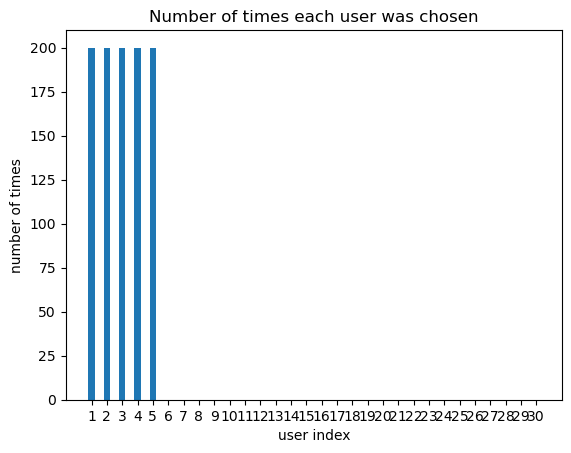

In [5]:


choices_table = np.zeros((args.global_epochs, args.num_users))
num_of_obs_arr = np.zeros((1,args.num_users))
train_loss_list = []
val_acc_list = []
val_losses_list = []
l1_norm_avg_deltha_theta_list = []
global_epochs_time_list = []


time_counter = 0
for global_epoch in tqdm(range(1, args.global_epochs+1)):
    """Part 1: Choosing Users"""
    for usr_idx in range(args.num_users):
        local_models[usr_idx].update_g(global_epoch)
        local_models[usr_idx].update_ucb(global_epoch)
    
    if args.choosing_users_verbose:
        print(f"iteration{global_epoch}")
    a=time.time()
    rounds_choise = utils.choose_users(local_models, args, method=args.method_choosing_users)

    
    #choices_table[global_epoch-1, rounds_choise] = 1
    num_of_obs_arr[0,rounds_choise] += 1
    for usr_idx in rounds_choise:
        local_models[usr_idx].update_emp_avg()
        local_models[usr_idx].update_privacy_violation_and_reward()
        local_models[usr_idx].increase_num_of_obs()
        if args.choosing_users_verbose:
            print(f"user {usr_idx}, g: {local_models[usr_idx].g}, ucb: {local_models[usr_idx].ucb}, num_of_obs: {local_models[usr_idx].num_of_obs}, privacy reward: {local_models[usr_idx].privacy_reward}, curr_delay = {local_models[usr_idx].last_access_time}")
    
    max_delay = max([local_models[i].last_access_time for i in rounds_choise])
    if args.choosing_users_verbose:
        print(f"max_delay = {max_delay:.2f} seconds")
    
    
    """Part 2: Training"""
    learning_utils.distribute_model(local_models, global_model)
    users_avg_loss_over_local_epochs = []

    for user_idx in rounds_choise:
        user_loss = []
        for local_epoch in range(args.local_epochs):
            user = local_models[user_idx]
            train_loss = learning_utils.train_one_epoch(user, train_criterion, args)
            if args.lr_scheduler:
                user.scheduler.step(train_loss)
            user_loss.append(train_loss)
        users_avg_loss_over_local_epochs.append(mean(user_loss))
    
    avg_loss_over_chosen_users_curr_global_epoch = mean(users_avg_loss_over_local_epochs)
    train_loss_list.append(avg_loss_over_chosen_users_curr_global_epoch)


    avg_deltha_theta = learning_utils.Fed_avg_models(local_models, global_model, rounds_choise,
                                                      args, snr_verbose = args.snr_verbose)
    # l1_norm_avg_deltha_theta = sum(LA.vector_norm(param.flatten(),1) for param in avg_deltha_theta.values())
    # l1_norm_avg_deltha_theta_list.append(l1_norm_avg_deltha_theta)
    # print(f"l1_norm_avg_deltha_theta is {l1_norm_avg_deltha_theta}")
    

    val_acc, val_loss = learning_utils.test(test_loader, global_model, test_criterion, args)
    val_acc_list.append(val_acc) ; val_losses_list.append(val_loss)
    

    # boardio.add_scalars("Losses over time in seconds", {"train_loss":avg_loss_over_chosen_users_curr_global_epoch,
    #                                     "val_loss": val_loss}, time.time()-start_time)
    # boardio.add_scalar('Val Accuracy', val_acc, time.time()-start_time)


    time_counter += max_delay
    print((f"global epoch {global_epoch} has been done artifficialy in {max_delay:.2f} secs, the total time by now is {time_counter:.2f} \n with avg train loss {avg_loss_over_chosen_users_curr_global_epoch:.3f}, val loss {val_loss:.3f}, avg val acc {val_acc:.2f}%"))
    global_epochs_time_list.append(time_counter)
    gc.collect()


    if val_acc > best_val_acc and args.save_best_model:
        best_val_acc = val_acc
        torch.save({"model's state dict":global_model.state_dict(),
                    "train_loss_list": train_loss_list,
                    "val_acc_list": val_acc_list,
                    "val_losses_list": val_losses_list,
                    "global_epochs_time_list": global_epochs_time_list,
                    "num_of_users": args.num_users,
                    "num_of_users_per_round": args.num_users_per_round,
                    "l1_norm_avg_deltha_theta_list": l1_norm_avg_deltha_theta_list}
                    , path_best_model)
    
    
    torch.save({"model's state dict":global_model.state_dict(),
                "train_loss_list": train_loss_list,
                "val_acc_list": val_acc_list,
                "val_losses_list": val_losses_list,
                "global_epochs_time_list": global_epochs_time_list,
                "num_of_obs_arr": num_of_obs_arr.reshape(-1),
                "global_epoch": global_epoch,
                "num_of_users": args.num_users,
                "num_of_users_per_round": args.num_users_per_round,
                "l1_norm_avg_deltha_theta_list": l1_norm_avg_deltha_theta_list}
                , last_model_path)

    if time_counter > args.max_seconds:
        break

users_idxs = tuple([str(x) for x in range(1,args.num_users+1)])
fig, ax = plt.subplots()
ax.bar(users_idxs, num_of_obs_arr.reshape(-1), width = 0.4)
ax.set_title("Number of times each user was chosen")
ax.set_ylabel("number of times")
ax.set_xlabel("user index")
#boardio.add_figure("Number of times each user was chosen", fig, global_epoch)
plt.savefig(last_model_path.parent / "Number of times each user was chosen.png")

#choices_table = choices_table.cumsum(axis=0)
